# WRANGLE AND ANALYZE DATA
## Project: We Rate Dogs
#### By Odiba Anthony
***

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#functions">Functions Used</a></li>
<li><a href="#dw">Data Wrangling</a>
<ul>
<li><a href="#gd">Gathering Data</a></li>
<li><a href="#ad">Assessing Data</a></li>
<ul>
<li><a href="#va">Visual Assessment</a></li>
<li><a href="#pa">Programmatic Assessment</a></li>
<li><a href="#F">Findings(Quality and Tidiness Issues)</a></li>
</ul>
<li><a href=#cd>Cleaning Data </a></li>
</ul>
</li>
<li><a href="#sav">Storing, Analyzing and Visualizing Wrangled Data</a></li>
<ul>
<li><a href="#1">Insight 1 & visualization</a></li>
<li><a href="#2">Insight 2 & visualization</a></li>
<li><a href="#3">Insight 3 & visualization</a></li>
<li><a href="#4">Insight 4 & visualization</a></li>
</ul>
</ul>
***

<a id='intro'></a>
## Introduction

The goal of this project is to showcase my wrangling skills by wrangling WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. To do this we need to gather additional data, then assess and clean it only then can produce a worthy analysis and visualization. 

Let's Begin!

We begin by importing all the Relevant Packages

In [675]:
#import all the packages needed
import os
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import string
import time
import re
%matplotlib inline
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import pandas_profiling
import missingno as msno
from IPython.display import display_pretty,display,Image

***

<a id="functions"></a>
## Functions Used

In [3]:
"""Wrote a function to find out the percentage of records that are missing in each of our 3 datasets"""
def percent_missing(dataset,dataset_name):
    total_cells=np.product(dataset.shape)
    missing_values_count=dataset.isnull().sum()
    total_missing=missing_values_count.sum()
    percent_missing=(total_missing/total_cells)*100
    print("%.2f%% of the %s dataset is missing." %(percent_missing,dataset_name))

In [4]:
"""Used in 'Cleaning Data' section to re-identify if text contains each column header. 
The function Includes text if it is found. If not, return NaN. 
Uses for loop and .str.contains() """
def get_dog_type(row):
    for i in dog_types:
        if i in row['text']:
            row[i]=i
        else:
            row[i]=np.NAN
    return row

In [5]:
#%%time
#def get_actual_dogType(df, dog_type):
#    dog_list = []
#    for row in df['text']:
#        if dog_type in row:
#            dog_list.append(dog_type)
#        else:
#            dog_list.append(np.NaN)
#    return dog_list

#for dog_type in dog_types:
#    archive_df_clean[dog_type] = get_actual_dogType(archive_df_clean, dog_type)

In [83]:
"""create a seperate column for the dog stages"""
archive_df_clean1['dog_stages']=np.NAN
def column_for_dog_stage(row):
    dog_stage=[]
    for i in dog_types:
        if row[i]==i:
            dog_stage.append(i)
        else:
            row[i]=np.NAN

        if len(dog_stage)<1:
            pass
        else:
            row['dog_stages']=','.join(dog_stage)
    return row

In [7]:
#def replace_names(row):
#    # Only try to replace name if it is 'a'
#    #if row['name'] == 'a':
#    #initially removed a from list to check for the other names in word list
#    if row['name'] in lowercase_names:
#        #get text from row
#        text = row['text']
#        
#        # get list of words from the text
#        word_list = text.split()
#        
#        #initially set the name to not sure in order to analyze 
#        #the accompanying text to see if they did in fact have name
#        name = 'Not sure' 
#        #name='None'
#        
#        if 'named' in word_list:
#            name_pos = word_list.index('named') + 1
#            name = word_list[name_pos]

#        elif 'name is' in text:
#            name_pos = word_list.index('name') + 2
#            name = word_list[name_pos]
#        row['name'] = name.replace('.','')
#        
#    return row
#archive_df_clean_name = archive_df_clean_name.apply(replace_names, axis=1)

In [8]:
def actual_names(row):
    #replace name if it is in word_list
    #initially removed a from list to check for the other names in word list
    text=row['text']
    name="None"
    if row['name'] in lowercase_names:
        word_list = text.split()
        #initially set the name to not sure in order to analyze 
        #the accompanying text to see if they did in fact have name
        #name = 'Not sure' 
        if 'named' in word_list:
            name_pos = word_list.index('named') + 1
            name = word_list[name_pos]

        elif 'called' in text:
            name_pos=word_list.index('called') +2
            name =word_list[name_pos]
        
        elif 'name is' in text:
            name_pos = word_list.index('name') + 2
            name = word_list[name_pos]        
        row['name'] = name.replace('.','')#only replace the 'name' column (with no period)
    else:
        first_period = text.find(".")
        if first_period == -1:#. is last element in list meaning no name 
            pass
        
        else:
            word_before = text[:first_period].rsplit(' ', 1)[-1]# Find word before period
            if word_before == word_before.title():
                # Add exclusionary criteria - not more than 10 letters, not less than 2 letters, 
                #not in other_words, only alphanumeric
                other_words = ["This", "Xbox", "Oh", "Christmas", "Up", "Pupper", "Doggo", "Puppo", "Floofer"]
                if ((len(word_before) > 10) or 
                    any(word in word_before for word in other_words) or 
                    any(c for c in word_before if c not in string.ascii_letters + "'") or 
                    (len(word_before) < 2)):
                    pass
                
                else:
                    name=word_before
            else:
                pass
    if row['name'] == 'None':
        row['name']=np.NAN
    return row

In [9]:
#used to replace the correct decimal value in the numerator column
def decimal_rating(row):
    decimal_pattern = '(\d+\.\d+)\/(\d+)'
    matches = re.search(decimal_pattern, row['text'])
    if matches != None:
        row['rating_numerator'] = float(matches.group(1))
        row['rating_denominator'] = float(matches.group(2))
    return row

In [10]:
#used to replace the correct rating values for the entries with two values that were misassigned
def valid_rating(row):
    valid_rating_pattern = '(?:(\d+\.?\d*\/\d+\.?\d*)\D+((\d+\.?\d*)\/(\d+\.?\d)))'
    matches = re.search(valid_rating_pattern, row['text'])
    if matches != None:
        row['rating_numerator'] = float(matches.group(3))
        row['rating_denominator'] = float(matches.group(4))
    return row

In [11]:
#used in cleaning numerator/denominator values that have unstandardized rating
def standardize_rating(row):
    if row['tweet_id'] in unstandardized_tweet_ids:
        row['rating_numerator']=row['rating_numerator']/row['rating_denominator']*10
        row['rating_denominator']=float(10)
    else:
        pass
    return row

In [757]:
#used to create the two extra columns for the prediction image df; confidence level and dog type
#dog_type = []
#confidence_level = []
def conf_and_type3(df):
    dog_type = []
    confidence_level = [] 

    if (df['p1_dog'] and df['p2_dog'] and df['p3_dog']) == True:
        max_conf=max(df['p1_dog'],df['p2_dog'],df['p3_dog'])
        confidence_level.append(max_conf)
        if max_conf == df['p1_dog']:
            dog_type.append(df['p1'])
        elif ma_conf == df['p2_dog']:
            dog_type.append(df['p2'])
        else:
            dog_type.append(df['p3'])
    
    #elif df['p1_dog'] or df['p2_dog'] or df['p3_dog'] == True:
    #    max_conf2=max(df['p1_dog'],df['p2_dog'],df['p3_dog'])
    #    dog_type.append('not_certain')
    #    confidence_level.append(max_conf2)
    
    elif (df['p1_dog'] and df['p2_dog'] and df['p3_dog']) == False:
        dog_type.append('not_dog')
        confidence_level.append(np.NAN)
                                
    else:
        pass
    return(dog_type,confidence_level)

In [758]:
#final
#used to create the two extra columns for the prediction image df; confidence level and dog type
dog_type = []
confidence_level = []
def conf_and_type2(df):
    #dog_type = []
    #confidence_level = [] 

    if (df['p1_dog'] and df['p2_dog'] and df['p3_dog']) == True:
        max_conf=max(df['p1_conf'],df['p2_conf'],df['p3_conf'])
        confidence_level.append(max_conf)
        if max_conf == df['p1_conf']:
            dog_type.append(df['p1'])
        elif max_conf == df['p2_conf']:
            dog_type.append(df['p2'])
        else:
            dog_type.append(df['p3'])
    
    elif (df['p1_dog'] or df['p2_dog'] or df['p3_dog']) == True:
        #max_conf2=max(df['p1_conf'],df['p2_conf'],df['p3_conf'])
        find_max=[]
        if df['p1_dog']==True:
            find_max.append(df['p1_conf'])
        elif df['p2_dog']==True:
            find_max.append(df['p2_conf'])
        elif df['p3_dog']==True:
            find_max.append(df['p3_conf'])
        else:
            pass
            
        max_conf3=max(find_max)
        confidence_level.append(max_conf3)
        
        if df['p1_conf']==max_conf3:
            dog_type.append(df['p1'])
        elif df['p2_conf']==max_conf3:
            dog_type.append(df['p2'])
        elif df['p3_conf']==max_conf3:
            dog_type.append(df['p3'])
        else:
            pass
        #dog_type.append('not_certain')
        #confidence_level.append(max_conf2)
    
    elif (df['p1_dog'] and df['p2_dog'] and df['p3_dog']) == False:
        dog_type.append('not_dog')
        confidence_level.append(np.NAN)
                                
    else:
        pass

    #return dog_type,confidence_level

***

<a id='dw'></a>
## Data Wrangling

<a id='gd'></a>
### Gathering Data
Three pieces of data are gathered;

* The WeRateDogs Twitter archive; Downloaded manually from [twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)

* The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. Downloaded programmatically using the Requests library. 

* Each tweet's retweet count and favorite ("like") count at minimum, and any additional data we find interesting. Use Twitter API for each tweet's JSON data using Python's Tweepy library.

In [13]:
!pwd
!ls -1t | head -5

/Users/lekekehinde/Desktop/ODIBA/UDACITY
Wrangle_Act.ipynb
api_archive_final.csv
predict_final.csv
predict_stacked.csv
twitter_archive_master.csv


#### WeRateDogs Twitter Achive

In [14]:
#Local file, contains basic tweet data, but not everything.
archive_df=pd.read_csv('twitter-archive-enhanced.csv')

#### Tweet Image Predictions

> Hosted on udacity's server and downloaded programmatically using Request's library!


In [15]:
#create a folder 
folder_name='image_predictions_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [16]:
#Packages the request, send the request and catch the response: r
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url,stream=True)

In [17]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

In [18]:
#os.path.abspath('image-predictions.tsv')

In [19]:
image_predictions_df=pd.read_csv('image_predictions_data/image-predictions.tsv',sep='\t')

#### Data from Twitter Api

In [20]:
consumer_key = 'Hidden'
consumer_secret = 'Hidden'
access_token = 'Hidden'
access_secret = 'Hidden'

try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
except tweepy.TweepError as e:
    #print(e.args[0][0]['code'])
    #print(e.args[0][0]['message'])
    print('{1} \n {2}'.format(e.args[0][0]['code'], e.args[0][0]['message']))
    
    
api = tweepy.API(auth,
                 parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

In [21]:
#%%timeit
start=time.time()
tweets_ids=archive_df['tweet_id']
tweet_data=[]
found_tweets=[]
missing_tweets=[]

#where favourite_count is how many favourites the tweet has
for ids in tweets_ids:
    try:
        temp_data=api.get_status(ids,tweet_mode='extended')
        tweet_data.append({'tweet_id':temp_data['id'],
                           'created_at':temp_data['created_at'],
                           'favorite_count':temp_data['favorite_count'],
                           'favorited':temp_data['favorited'],
                           'User_followers':temp_data['user']['followers_count'],
                           'retweet_count':temp_data['retweet_count'],
                           'retweeted':temp_data['retweeted']})
        found_tweets.append(ids)
        print(str(ids) + ' : Success')
    
    except tweepy.TweepError as e:
        missing_tweets.append(ids)
        print(str(ids)+ ' is missing')
        print('{} : {}'.format(ids,e))
end=time.time()
print('The code in this cell ran for %.2f minutes!' %((end-start)/60))

892420643555336193 : Success
892177421306343426 : Success
891815181378084864 : Success
891689557279858688 : Success
891327558926688256 : Success
891087950875897856 : Success
890971913173991426 : Success
890729181411237888 : Success
890609185150312448 : Success
890240255349198849 : Success
890006608113172480 : Success
889880896479866881 : Success
889665388333682689 : Success
889638837579907072 : Success
889531135344209921 : Success
889278841981685760 : Success
888917238123831296 : Success
888804989199671297 : Success
888554962724278272 : Success
888202515573088257 is missing
888202515573088257 : [{'code': 144, 'message': 'No status found with that ID.'}]
888078434458587136 : Success
887705289381826560 : Success
887517139158093824 : Success
887473957103951883 : Success
887343217045368832 : Success
887101392804085760 : Success
886983233522544640 : Success
886736880519319552 : Success
886680336477933568 : Success
886366144734445568 : Success
886267009285017600 : Success
886258384151887873 

844223788422217728 : Success
843981021012017153 : Success
843856843873095681 : Success
843604394117681152 : Success
843235543001513987 : Success
842892208864923648 is missing
842892208864923648 : [{'code': 144, 'message': 'No status found with that ID.'}]
842846295480000512 : Success
842765311967449089 : Success
842535590457499648 : Success
842163532590374912 : Success
842115215311396866 : Success
841833993020538882 : Success
841680585030541313 : Success
841439858740625411 : Success
841320156043304961 : Success
841314665196081154 : Success
841077006473256960 : Success
840761248237133825 : Success
840728873075638272 : Success
840698636975636481 : Success
840696689258311684 : Success
840632337062862849 : Success
840370681858686976 : Success
840268004936019968 : Success
839990271299457024 : Success
839549326359670784 : Success
839290600511926273 : Success
839239871831150596 : Success
838952994649550848 : Success
838921590096166913 : Success
838916489579200512 : Success
838831947270979586 

808733504066486276 : Success
808501579447930884 : Success
808344865868283904 : Success
808134635716833280 : Success
808106460588765185 : Success
808001312164028416 : Success
807621403335917568 : Success
807106840509214720 : Success
807059379405148160 : Success
807010152071229440 : Success
806629075125202948 : Success
806620845233815552 : Success
806576416489959424 : Success
806542213899489280 : Success
806242860592926720 : Success
806219024703037440 : Success
805958939288408065 : Success
805932879469572096 : Success
805826884734976000 : Success
805823200554876929 : Success
805520635690676224 : Success
805487436403003392 : Success
805207613751304193 : Success
804738756058218496 : Success
804475857670639616 : Success
804413760345620481 : Success
804026241225523202 : Success
803773340896923648 : Success
803692223237865472 : Success
803638050916102144 : Success
803380650405482500 : Success
803321560782307329 : Success
803276597545603072 : Success
802952499103731712 : Success
80262471331903

772117678702071809 : Success
772114945936949249 : Success
772102971039580160 : Success
771908950375665664 : Success
771770456517009408 : Success
771500966810099713 : Success
771380798096281600 : Success
771171053431250945 : Success
771136648247640064 : Success
771102124360998913 : Success
771014301343748096 : Success
771004394259247104 : Success
770787852854652928 : Success
770772759874076672 : Success
770743923962707968 is missing
770743923962707968 : [{'code': 144, 'message': 'No status found with that ID.'}]
770655142660169732 : Success
770414278348247044 : Success
770293558247038976 : Success
770093767776997377 : Success
770069151037685760 : Success
769940425801170949 : Success
769695466921623552 : Success
769335591808995329 : Success
769212283578875904 : Success
768970937022709760 : Success
768909767477751808 : Success
768855141948723200 : Success
768609597686943744 : Success
768596291618299904 : Success
768554158521745409 : Success
768473857036525572 : Success
768193404517830656 

738885046782832640 : Success
738883359779196928 : Success
738537504001953792 : Success
738402415918125056 : Success
738184450748633089 : Success
738166403467907072 : Success
738156290900254721 : Success
737826014890496000 : Success
737800304142471168 : Success
737678689543020544 : Success
737445876994609152 : Success
737322739594330112 : Success
737310737551491075 : Success
736736130620620800 : Success
736392552031657984 : Success
736365877722001409 : Success
736225175608430592 : Success
736010884653420544 : Success
735991953473572864 : Success
735648611367784448 : Success
735635087207878657 : Success
735274964362878976 : Success
735256018284875776 : Success
735137028879360001 : Success
734912297295085568 : Success
734787690684657664 : Success
734776360183431168 : Success
734559631394082816 : Success
733828123016450049 : Success
733822306246479872 : Success
733482008106668032 : Success
733460102733135873 : Success
733109485275860992 : Success
732732193018155009 : Success
73272608572558

702899151802126337 : Success
702684942141153280 : Success
702671118226825216 : Success
702598099714314240 : Success
702539513671897089 : Success
702332542343577600 : Success
702321140488925184 : Success
702276748847800320 : Success
702217446468493312 : Success
701981390485725185 : Success
701952816642965504 : Success
701889187134500865 : Success
701805642395348998 : Success
701601587219795968 : Success
701570477911896070 : Success
701545186879471618 : Success
701214700881756160 : Success
700890391244103680 : Success
700864154249383937 : Success
700847567345688576 : Success
700796979434098688 : Success
700747788515020802 : Success
700518061187723268 : Success
700505138482569216 : Success
700462010979500032 : Success
700167517596164096 : Success
700151421916807169 : Success
700143752053182464 : Success
700062718104104960 : Success
700029284593901568 : Success
700002074055016451 : Success
699801817392291840 : Success
699788877217865730 : Success
699779630832685056 : Success
69977587880970

683828599284170753 : Success
683773439333797890 : Success
683742671509258241 : Success
683515932363329536 : Success
683498322573824003 : Success
683481228088049664 : Success
683462770029932544 : Success
683449695444799489 : Success
683391852557561860 : Success
683357973142474752 : Success
683142553609318400 : Success
683111407806746624 : Success
683098815881154561 : Success
683078886620553216 : Success
683030066213818368 : Success
682962037429899265 : Success
682808988178739200 : Success
682788441537560576 : Success
682750546109968385 : Success
682697186228989953 : Success
682662431982772225 : Success
682638830361513985 : Success
682429480204398592 : Success
682406705142087680 : Success
682393905736888321 : Success
682389078323662849 : Success
682303737705140231 : Success
682259524040966145 : Success
682242692827447297 : Success
682088079302213632 : Success
682059653698686977 : Success
682047327939461121 : Success
682032003584274432 : Success
682003177596559360 : Success
68198116709712

674051556661161984 : Success
674045139690631169 : Success
674042553264685056 : Success
674038233588723717 : Success
674036086168010753 : Success
674024893172875264 : Success
674019345211760640 : Success
674014384960745472 : Success
674008982932058114 : Success
673956914389192708 : Success
673919437611909120 : Success
673906403526995968 : Success
673887867907739649 : Success
673716320723169284 : Success
673715861853720576 : Success
673711475735838725 : Success
673709992831262724 : Success
673708611235921920 : Success
673707060090052608 : Success
673705679337693185 : Success
673700254269775872 : Success
673697980713705472 : Success
673689733134946305 : Success
673688752737402881 : Success
673686845050527744 : Success
673680198160809984 : Success
673662677122719744 : Success
673656262056419329 : Success
673636718965334016 : Success
673612854080196609 : Success
673583129559498752 : Success
673580926094458881 : Success
673576835670777856 : Success
673363615379013632 : Success
67335981873698

668620235289837568 : Success
668614819948453888 : Success
668587383441514497 : Success
668567822092664832 : Success
668544745690562560 : Success
668542336805281792 : Success
668537837512433665 : Success
668528771708952576 : Success
668507509523615744 : Success
668496999348633600 : Success
668484198282485761 : Success
668480044826800133 : Success
668466899341221888 : Success
668297328638447616 : Success
668291999406125056 : Success
668286279830867968 : Success
668274247790391296 : Success
668268907921326080 : Success
668256321989451776 : Success
668248472370458624 : Success
668237644992782336 : Success
668226093875376128 : Success
668221241640230912 : Success
668204964695683073 : Success
668190681446379520 : Success
668171859951755264 : Success
668154635664932864 : Success
668142349051129856 : Success
668113020489474048 : Success
667937095915278337 : Success
667924896115245057 : Success
667915453470232577 : Success
667911425562669056 : Success
667902449697558528 : Success
66788692128524

In [22]:
# Write tweet data to json file
with open('tweet_json.txt', mode = 'w') as outfile:
    json.dump(tweet_data, outfile)

In [23]:
api_twitter_df=pd.read_json('tweet_json.txt')

In [24]:
api_twitter_df.sample(10)

,User_followers,created_at,favorite_count,favorited,retweet_count,retweeted,tweet_id
1950,8117729,2015-12-06 01:48:12,878,False,264,False,673317986296586240
1015,8117704,2016-06-21 02:03:25,8097,False,3707,False,745074613265149952
1560,8117719,2016-01-13 16:56:30,20771,False,9590,False,687317306314240000
1060,8117707,2016-06-05 15:54:48,7401,False,3066,False,739485634323156992
1409,8117717,2016-02-11 03:57:11,1806,False,565,False,697630435728322560
3,8117686,2017-07-30 15:58:51,40801,False,8317,False,891689557279858688
2152,8117729,2015-11-25 01:35:25,1021,False,422,False,669328503091937280
1360,8117716,2016-02-22 00:53:31,2903,False,969,False,701570477911896070
141,8117688,2017-05-13 16:33:49,23507,False,5194,False,863432100342583297
287,8117692,2017-03-01 17:22:13,13139,False,2417,False,836989968035819520


In [25]:
 assert np.all(api_twitter_df.tweet_id) == np.all(found_tweets)

In [26]:
len(missing_tweets)

19

***

<a id='ad'></a>
### ASSESSING DATA

<a id="va"></a>
#### Visual Assessment

In [27]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [28]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [29]:
api_twitter_df.head()

,User_followers,created_at,favorite_count,favorited,retweet_count,retweeted,tweet_id
0,8117686,2017-08-01 16:23:56,37471,False,8162,False,892420643555336193
1,8117686,2017-08-01 00:17:27,32213,False,6042,False,892177421306343426
2,8117686,2017-07-31 00:18:03,24281,False,3999,False,891815181378084864
3,8117686,2017-07-30 15:58:51,40801,False,8317,False,891689557279858688
4,8117686,2017-07-29 16:00:24,39016,False,9011,False,891327558926688256


<a id='pa'></a>
#### Programmatic Assessment

In [30]:
#list of dataframes
diff_twitter_data=['archive_df','image_predictions_df','api_twitter_df']

In [31]:
for i in diff_twitter_data:
    percent_missing(eval(i),i)

27.81% of the archive_df dataset is missing.
0.00% of the image_predictions_df dataset is missing.
0.00% of the api_twitter_df dataset is missing.


#### Archive Twittter Data

In [32]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [33]:
archive_df.tweet_id.nunique()

2356

In [34]:
sum(archive_df.duplicated())

0

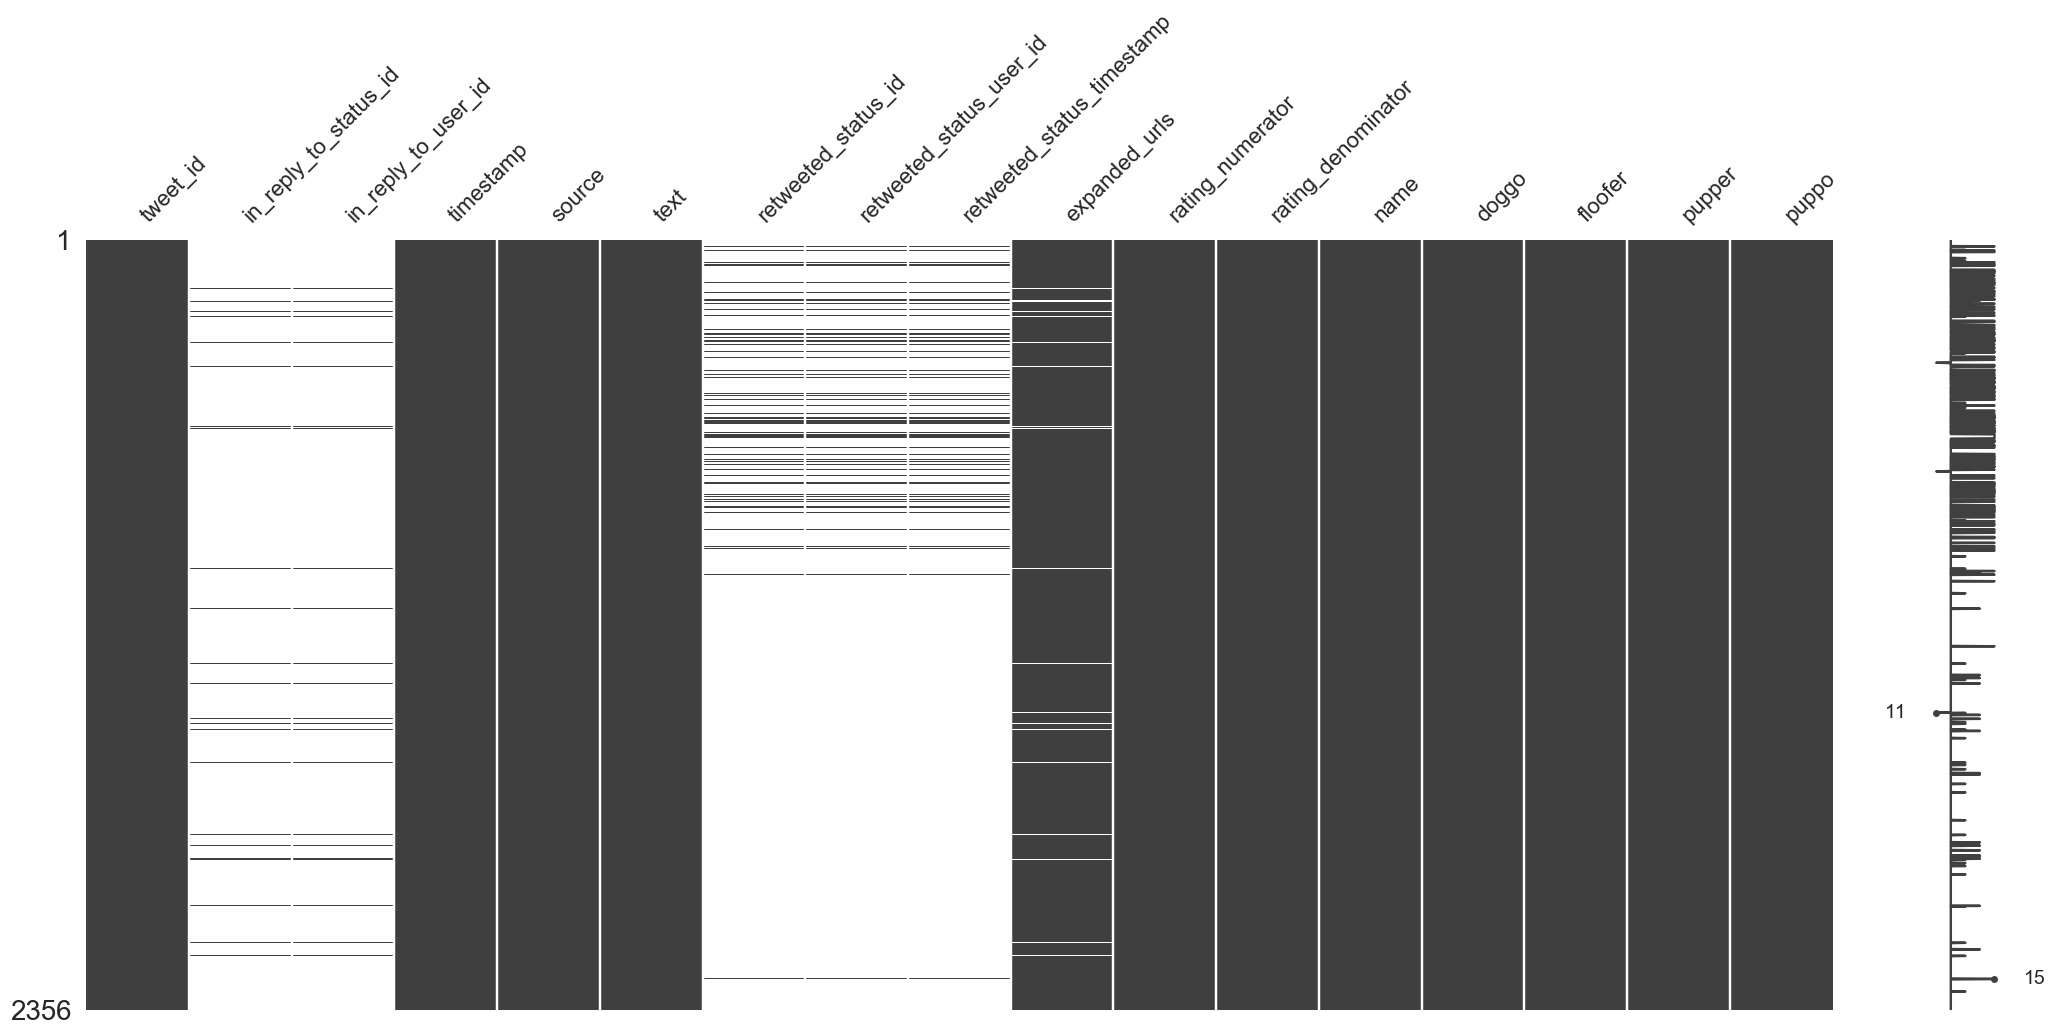

In [45]:
#check out the level of missing data
msno.matrix(archive_df)

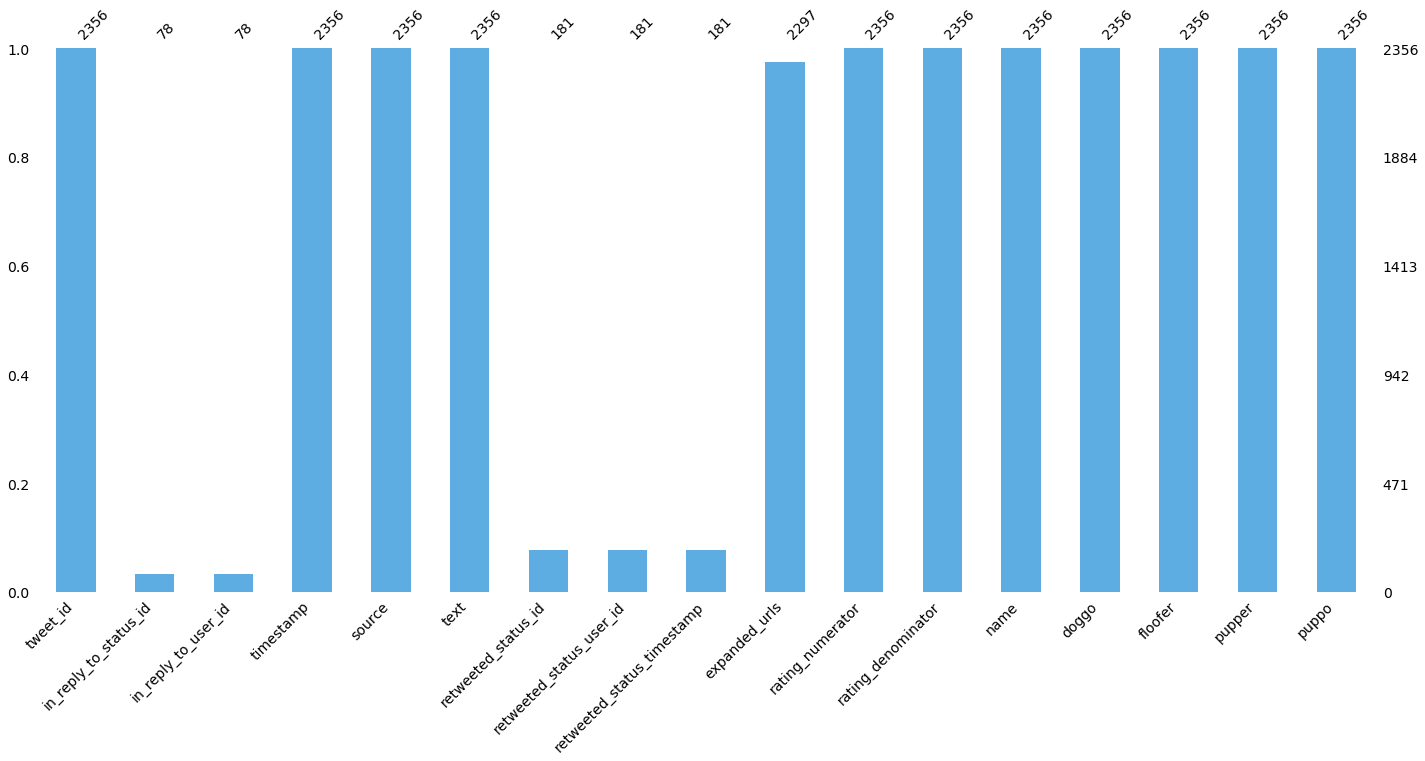

In [43]:
msno.bar(archive_df,fontsize=14,color='#5DADE2')

In [759]:
#pandas_profiling.ProfileReport(archive_df)

For puppo, pupper, floofere and doggo variables each of these columns has two values; 1st a None value and the second value with the same name as the column name. Let's see if the frequency of these two values in each variable aligns with the name extracted from the Text column.


In [46]:
# Count number of not 'None' values in columns 'doggo' to 'puppo'
(archive_df.loc[:,'doggo':'puppo'] != 'None').sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [47]:
for column in archive_df.columns[-4:]:
    print(column,archive_df.text.str.contains(column).sum())

doggo 98
floofer 4
pupper 272
puppo 37


In [48]:
archive_df[['text','name']].sample(10,random_state=136)

,text,name
1436,Meet Charlie. He likes to kiss all the big mil...,Charlie
1347,Say hello to Bisquick. He's a Beneplop Cumbers...,Bisquick
2273,This is a northern Wahoo named Kohl. He runs t...,a
22,I've yet to rate a Venezuelan Hover Wiener. Th...,such
2226,Meet Sophie. Her son just got in the car to le...,Sophie
1402,"""Don't ever talk to me or my son again."" ...bo...",None
2339,Oh my. Here you are seeing an Adobe Setter giv...,None
472,Meet Moose. He doesn't want his friend to go b...,Moose
2355,Here we have a Japanese Irish Setter. Lost eye...,None
197,This is Arya. She can barely contain her excit...,Arya


In [49]:
#explore contents of the text column with corresponding 'None' and 'a' values in Name column

In [50]:
#name a
archive_df.text[2273]

'This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk'

In [51]:
#named wrongle as "such"
archive_df.text[22]

"I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba"

In [52]:
#name None
archive_df.text[2355]

'Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj'

In [53]:
archive_df.text[2232]

'These two dogs are Bo &amp; Smittens. Smittens is trying out a new deodorant and wanted Bo to smell it. 10/10 true pals https://t.co/4pw1QQ6udh'

In [56]:
archive_df[['text','name']][archive_df.name =='None'].sample(5)

,text,name
615,RT @dog_rates: I want to finally rate this ico...,None
2112,Two unbelievably athletic dogs here. Great for...,None
1304,"""I shall trip the big pupper with leash. Big p...",None
1654,I just want to be friends with this dog. Appea...,None
1053,Was just informed about this hero pupper and o...,None


In [57]:
#a name is clearly stated but it isn't captured in the name column
archive_df.loc[[72],['text','name']]

,text,name
72,Martha is stunning how h*ckin dare you. 13/10 ...,None


In [58]:
#lets explore the rating numerator and denominator

In [59]:
#find out the rating denominator values that occure the least fe=requent and explore them
archive_df.rating_denominator.value_counts()<3

10     False
11     False
50     False
80      True
20      True
2       True
16      True
40      True
70      True
15      True
90      True
110     True
120     True
130     True
150     True
170     True
7       True
0       True
Name: rating_denominator, dtype: bool

In [60]:
#blacklist=[10,11,50]
#ix=[i for i in archive_df.rating_denominator.unique() if i not in blacklist]
#with pd.option_context('display.max_colwidth', 200):
#     display(archive_df[['tweet_id','text','rating_denominator']][archive_df.rating_denominator.isin(ix)])

In [61]:
with pd.option_context('display.max_colwidth',200):
    display(archive_df[['tweet_id','text','rating_denominator']][~archive_df.rating_denominator.isin([10,11,50])])

,tweet_id,text,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,832088576586297345,@docmisterio account started on 11/15/15,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,40


We can clearly see that some of the ratings extracted were the incorrect value as seen from tweets with id **810984652412424192, 722974582966214656** etc. Some of the ratings are from more than one dog, while some aren't ratings at all .E.g **722974582966214656, 835246439529840640**

In [62]:
#for rating numerator
archive_df.rating_numerator.value_counts()<3

12      False
11      False
10      False
13      False
9       False
8       False
7       False
14      False
5       False
6       False
3       False
4       False
1       False
2       False
420      True
0        True
15       True
75       True
80       True
20       True
24       True
26       True
44       True
50       True
60       True
165      True
84       True
88       True
144      True
182      True
143      True
666      True
960      True
1776     True
17       True
27       True
45       True
99       True
121      True
204      True
Name: rating_numerator, dtype: bool

In [63]:
#lets sample a few of those values with numerator occuring less than 3 times
with pd.option_context('display.max_colwidth',200):
    display(archive_df[['tweet_id','text','rating_numerator']][archive_df.rating_numerator.isin([420,17,27,99,24,50,60])])

,tweet_id,text,rating_numerator
55,881633300179243008,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60
2074,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420


**We can see that some of the tweets are not actual dog ratings but refere to something else**

In [64]:
#let's explore values that have decimal numerators
with pd.option_context('display.max_colwidth',200):
    display(archive_df[archive_df['text'].str.contains(r"(?:(?:[-+]?\d+\.\d+\/\d+)|(?:[-+]?\d+\.\/\d+))")][['tweet_id','text','rating_numerator']])

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [65]:
#info for dataframe with original tweets
archive_df[archive_df.retweeted_status_id.isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

#### Image Predictions Data

In [66]:
image_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1429,772877495989305348,https://pbs.twimg.com/ext_tw_video_thumb/77287...,1,tabby,0.218303,False,Norwegian_elkhound,0.138523,True,wombat,0.074217,False
2064,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
1183,738537504001953792,https://pbs.twimg.com/media/Cj_P7rSUgAAYQbz.jpg,1,chow,0.808737,True,gibbon,0.028942,False,Pembroke,0.026498,True
593,679475951516934144,https://pbs.twimg.com/media/CW37xZbUoAAUXe5.jpg,1,Maltese_dog,0.145742,True,toy_poodle,0.139407,True,West_Highland_white_terrier,0.108821,True
1259,748699167502000129,https://pbs.twimg.com/media/CmPp5pOXgAAD_SG.jpg,1,Pembroke,0.849029,True,Cardigan,0.083629,True,kelpie,0.024394,True


In [67]:
#number of the predictor columns contains an animal that isnt a dog
len(image_predictions_df[(image_predictions_df['p1_dog']== False) | (image_predictions_df['p2_dog'] == False) | (image_predictions_df['p3_dog'] == False)])

832

In [68]:
#number of the predictor entries in the three colunms that all contain an animal that was predicted to be something else
len(image_predictions_df[(image_predictions_df['p1_dog']== False) & (image_predictions_df['p2_dog'] == False) & (image_predictions_df['p3_dog'] == False)])

324

From the 2075 entries, there are 832 entries where there are chances that the image is not a dog. When I checked the length where the predictions all contain an animal that wasn't predicted as a dog i got 324 entries. Lets inspect the  rows of the 324.

In [69]:
temp_img_df=image_predictions_df[(image_predictions_df['p1_dog']== False) & (image_predictions_df['p2_dog'] == False) & (image_predictions_df['p3_dog'] == False)]
temp_img_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
361,672828477930868736,https://pbs.twimg.com/media/CVZd7ttWcAEs2wP.jpg,1,sandbar,0.118154,False,stingray,0.075915,False,seashore,0.075125,False
753,688179443353796608,https://pbs.twimg.com/media/CYznjAcUEAQ5Zq7.jpg,1,sorrel,0.811520,False,horse_cart,0.024820,False,Arabian_camel,0.015155,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
117,668142349051129856,https://pbs.twimg.com/media/CUW37BzWsAAlJlN.jpg,1,Angora,0.918834,False,hen,0.037793,False,wood_rabbit,0.011015,False
1688,815390420867969024,https://pbs.twimg.com/media/C1DZQiTXgAUqgRI.jpg,1,restaurant,0.279846,False,toyshop,0.091429,False,paper_towel,0.046147,False


we can see from a sample of the temporary datafram that some of the images predicted arent dogs

In [70]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [71]:
#Alternative way to check if any uses the same picure 
assert (image_predictions_df.jpg_url.value_counts()>1).any()

In [72]:
image_predictions_df.jpg_url.nunique()

2009

In [73]:
#check for the number of tweets using the same picture
sum(image_predictions_df.jpg_url.duplicated())

66

In [74]:
image_predictions_df.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [75]:
image_predictions_df[['p1_dog','p2_dog','p3_dog']].describe()

,p1_dog,p2_dog,p3_dog
count,2075,2075,2075
unique,2,2,2
top,True,True,True
freq,1532,1553,1499


#### Data Gotten from Twitter Api

In [76]:
api_twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 7 columns):
User_followers    2337 non-null int64
created_at        2337 non-null datetime64[ns]
favorite_count    2337 non-null int64
favorited         2337 non-null bool
retweet_count     2337 non-null int64
retweeted         2337 non-null bool
tweet_id          2337 non-null int64
dtypes: bool(2), datetime64[ns](1), int64(4)
memory usage: 95.9 KB


In [77]:
#pandas_profiling.ProfileReport(api_twitter_df)

In [78]:
#in in a series checks whether the value is in the index
681340665377193000 in api_twitter_df.tweet_id.unique()

False

***

<a id="F"></a>
#### FINDINGS: Quality and Tidiness Issues

From our functin we see that the dataframe with missing vallues is the Twitter Archive dataframe with ~28% missing we dive deeper using pandas profilling and we have a deeper view of the archive dataset like where the values are missing, the frequency of the values in each variable of the datasets etc. 

#### QUALITY ISSUES 

To determine the quality of the dataframes we check for content issues i.e completeness,consistency,Accuracy and Validity

***Twitter Archive Dataframe***
* Missing values from archive dataset
* Inacurate or Missing names.
* In several columns null objects are non-null (None to NaN). E.G name, doggo, floofer, pupper, and puppo have values that are the string "None" instead of NaN
* Data contains retweets ie. rows where retweeted_status_id and retweeted_status_user_id should be NaN
* The Numerator and Denominators have incorrect or inacurate ratings
* Incorrect Datatypes: 
i.e
 * Tweet_id is an integer, it should be a string
 * in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be integers or strings instead of float.
 * timestamp and retweeted_status_timestamp are object types



***Image Prediction Dataframe***
* Missing values from images dataset (2075 tweets in the image_prediction_df instead of 2356(archive_df)). 
This could mean that there is missing data, or that not all 2356 of the tweets had pictures.
* Tweet_id is an integer, it should be a string.
* Some tweet_ids have the same jpg_url.
* some images predicted aren't dogs.
* p1, p2, and p3 is incosistently capitalized, also contain dash and spaces insead of underscores instead in entries.

***Twitter Api Dataframe***
* There are 18 missing tweets compared to the twitter archive dataframe. The missing tweets may have been deleted.
* Retweeted and favorited information is not available for all tweets or it coluld not be retrieved. These two columns have a consistent False value and offers us no useful information for alalysis, hence those two columns should be dropped.(Also a tidiness issue)

#### **TIDINESS ISSUES**

* **Delete or Drop unnecessary columns**
* **Combine all the dataframes into one**

**Archive_df dataframe***
* doggo, floofer, pupper and puppo are all individual columns containingthe same data type variable (dog stage). They should be combined to a single column

**Image Prediction Dataframe***
* There are multiple columns containing the same type of data, e.g. p1, p2, p3 all contain dog breed predictions

***

<a id='cd'></a>
### CLEANING DATA

In [461]:
#duplicate each of the dataframes that we have the original datasets in case of mistakes
archive_df_clean = archive_df.copy()
predictions_df_clean = image_predictions_df.copy()
api_twitter_df_clean = api_twitter_df.copy()

Firstly, lets deal with missing Data

***

*** ISSUES: Missing Data***

* Missing counts for doggo, floofer, pupper and puppo columns in archive_df
* In several columns null objects are non-null (None to NaN). E.G name, doggo, floofer, pupper, and puppo have values that are the string "None" instead of NaN
* Inaccurate or Missing Names


**Approach**


***First approach***
* create two copies of the archive_df_clean dataframe
* In one copy, Use for loop and .str.contains() to re-identify if text contains each column header. Include text if it is found. If not, return NaN.
* create a seperate column for the dog stages

***Second Approach***
* In another copy, go ahead and create extra column with dog stages without re-identifying if the text contains each column header.
* Compare relevant entries in both copies

***Lastly***
* Determine the better approach then,
* Drop dog_types column

In [462]:
dog_types = list(archive_df.iloc[:,-4:])
dog_types

['doggo', 'floofer', 'pupper', 'puppo']

In [463]:
#use this copy for first step
archive_df_clean1=archive_df.copy()

**First Copy**

**Step 1**

In [464]:
%%time
archive_df_clean1=archive_df_clean1.apply(get_dog_type,axis=1)

CPU times: user 384 ms, sys: 9.35 ms, total: 393 ms
Wall time: 396 ms


**Step 2**
Create extra column

In [465]:
%%time
archive_df_clean1=archive_df_clean1.apply(column_for_dog_stage,axis=1)

CPU times: user 1.21 s, sys: 23.5 ms, total: 1.23 s
Wall time: 1.28 s


**Test to Confirm**

To test if our code worked, lets compare the original archive df with the new copy

In [466]:
# Count number of not 'None' values in columns 'doggo' to 'puppo' in the initial archive df
(archive_df.loc[:,'doggo':'puppo'] != 'None').sum()

doggo       97
floofer     10
pupper     257
puppo       30
dtype: int64

In [467]:
#how many times does each dog stage occure in each text column of each row entry in the new copy of the dataframe
for column in archive_df_clean.columns[-4:]:
    print(column,archive_df_clean.text.str.contains(column).sum())

doggo 98
floofer 4
pupper 272
puppo 37


In [468]:
#we see that it corresponds to the above values
archive_df_clean1[dog_types].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
doggo      98 non-null object
floofer    4 non-null object
pupper     272 non-null object
puppo      37 non-null object
dtypes: object(4)
memory usage: 73.7+ KB


In [469]:
# Count number of not 'None' values in columns 'doggo' to 'puppo' in the  new copy archive df
(archive_df_clean1.loc[:,['doggo','puppo','floofer','doggo']] != 'None').sum()

doggo      2356
puppo      2356
floofer    2356
doggo      2356
dtype: int64

In [470]:
#values counts for dog_stages column in First copy
archive_df_clean1['dog_stages'].value_counts()

pupper          262
doggo            86
puppo            35
doggo,pupper     10
floofer           4
doggo,puppo       2
Name: dog_stages, dtype: int64

In [471]:
#slice of the first copy dataframe highlighting the dog_stages column with more than one dog stage i.e 
#i.e two dog stage extracted from one 
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean1
            [['tweet_id','text',"doggo","floofer","pupper","puppo","dog_stages"]]
            [archive_df_clean1.dog_stages.isin(["doggo,pupper","doggo,puppo"])].sample(4))

,tweet_id,text,doggo,floofer,pupper,puppo,dog_stages
172,858843525470990336,I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq,doggo,NaN,NaN,puppo,"doggo,puppo"
575,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggo,NaN,pupper,NaN,"doggo,pupper"
822,770093767776997377,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggo,NaN,pupper,NaN,"doggo,pupper"
1113,733109485275860992,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,NaN,pupper,NaN,"doggo,pupper"


**Second Copy**

**Step 3**

In [472]:
%%time
#using archive_df_clean create a dog_stages column without reidentifying the columns
archive_df_clean=archive_df_clean.apply(column_for_dog_stage,axis=1)

CPU times: user 1.22 s, sys: 8.87 ms, total: 1.23 s
Wall time: 1.24 s


**Test to confirm**

Check the difference in value counts for the re-identified dataframe copy an this one

In [473]:
#values counts for dog_stages column in First copy
archive_df_clean['dog_stages'].value_counts()

pupper           245
doggo             83
puppo             29
doggo,pupper      12
floofer            9
doggo,floofer      1
doggo,puppo        1
Name: dog_stages, dtype: int64

Check the text for some of these categories to see with method extracted the dog stages better, thats the one we will go with.

In [474]:
#a slice of the dataframe showing the dog_stages column with more than one dog stage i.e two dog stage extracted from one 
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [['tweet_id','text',"doggo","floofer","pupper","puppo","dog_stages"]]
            [archive_df_clean.dog_stages.isin(["doggo,pupper","doggo,puppo"])].sample(4))

,tweet_id,text,doggo,floofer,pupper,puppo,dog_stages
565,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggo,NaN,pupper,NaN,"doggo,pupper"
531,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggo,NaN,pupper,NaN,"doggo,pupper"
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggo,NaN,pupper,NaN,"doggo,pupper"
822,770093767776997377,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggo,NaN,pupper,NaN,"doggo,pupper"


**Lets compare only the Floofer cartegory of the dog stages**

In [475]:
#a slice of the dataframe showing the dog_stages column that might be useful to help us decide. i.e floofer column 
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [['tweet_id','text',"doggo","floofer","pupper","puppo","dog_stages"]]
            [archive_df_clean.dog_stages.isin(["doggo,floofer","floofer"])])

,tweet_id,text,doggo,floofer,pupper,puppo,dog_stages
46,883360690899218434,Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck https://t.co/rf661IFEYP,NaN,floofer,NaN,NaN,floofer
200,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggo,floofer,NaN,NaN,"doggo,floofer"
582,800388270626521089,This is Doc. He takes time out of every day to worship our plant overlords. 12/10 quite the floofer https://t.co/azMneS6Ly5,NaN,floofer,NaN,NaN,floofer
774,776218204058357768,Atlas rolled around in some chalk and now he's a magical rainbow floofer. 13/10 please never take a bath https://t.co/nzqTNw0744,NaN,floofer,NaN,NaN,floofer
984,749317047558017024,This is Blu. He's a wild bush Floofer. I wish anything made me as happy as bushes make Blu. 12/10 would frolic with https://t.co/HHUAnBb6QB,NaN,floofer,NaN,NaN,floofer
1022,746542875601690625,Here's a golden floofer helping with the groceries. Bed got in way. Still 11/10 helpful af (vid by @categoen) https://t.co/6ZRoZUWFmd,NaN,floofer,NaN,NaN,floofer
1091,737445876994609152,Just wanted to share this super rare Rainbow Floofer in case you guys haven't seen it yet. 13/10 colorful af https://t.co/CaG9MzD3WT,NaN,floofer,NaN,NaN,floofer
1110,733822306246479872,This is Moose. He's a Polynesian Floofer. Dapper af. 10/10 would pet diligently https://t.co/mVfqRdppTL,NaN,floofer,NaN,NaN,floofer
1534,689993469801164801,Here we are witnessing a rare High Stepping Alaskan Floofer. 12/10 dangerously petable (vid by @TheMrsNux) https://t.co/K4s9IJh2jm,NaN,floofer,NaN,NaN,floofer
1614,685307451701334016,Say hello to Petrick. He's an Altostratus Floofer. Just had a run in with a trash bag. Groovy checkered floor. 11/10 https://t.co/rwW7z1JAOF,NaN,floofer,NaN,NaN,floofer


In [476]:
#list of missing floofer dog_stages entries that are present in the second copy 
missing_floofer=[883360690899218434,854010172552949760,
                 800388270626521089,776218204058357768,
                 749317047558017024,746542875601690625,
                 737445876994609152,733822306246479872,
                 689993469801164801,685307451701334016]

In [477]:
#slice of the first copy dataframe highlighting the missing floofer dog_stages entries that are present in the second copy 
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean1
            [['tweet_id','text',"doggo","floofer","pupper","puppo","dog_stages"]]
            [archive_df_clean1.tweet_id.isin(missing_floofer)].sample(7))

,tweet_id,text,doggo,floofer,pupper,puppo,dog_stages
774,776218204058357768,Atlas rolled around in some chalk and now he's a magical rainbow floofer. 13/10 please never take a bath https://t.co/nzqTNw0744,NaN,floofer,NaN,NaN,floofer
1534,689993469801164801,Here we are witnessing a rare High Stepping Alaskan Floofer. 12/10 dangerously petable (vid by @TheMrsNux) https://t.co/K4s9IJh2jm,NaN,NaN,NaN,NaN,NaN
1091,737445876994609152,Just wanted to share this super rare Rainbow Floofer in case you guys haven't seen it yet. 13/10 colorful af https://t.co/CaG9MzD3WT,NaN,NaN,NaN,NaN,NaN
582,800388270626521089,This is Doc. He takes time out of every day to worship our plant overlords. 12/10 quite the floofer https://t.co/azMneS6Ly5,NaN,floofer,NaN,NaN,floofer
1110,733822306246479872,This is Moose. He's a Polynesian Floofer. Dapper af. 10/10 would pet diligently https://t.co/mVfqRdppTL,NaN,NaN,NaN,NaN,NaN
1614,685307451701334016,Say hello to Petrick. He's an Altostratus Floofer. Just had a run in with a trash bag. Groovy checkered floor. 11/10 https://t.co/rwW7z1JAOF,NaN,NaN,NaN,NaN,NaN
1022,746542875601690625,Here's a golden floofer helping with the groceries. Bed got in way. Still 11/10 helpful af (vid by @categoen) https://t.co/6ZRoZUWFmd,NaN,floofer,NaN,NaN,floofer


>**We see that in the first approach, re-identifying the dog stage using the text column isn't the best approach because it isn't accurate. Therefor we go with the second approach. i.e run the function ***column_for_dog_stages*** on the copy of the archive_df to create the dog_stages column and then drop the other columns.**

This also serves to address the tidyness issue as different columns representing various dog stages has been combined to form one column 

In [478]:
#Drop doggo, floofer, pupper, and puppo columns
archive_df_clean = archive_df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

***

**Issue: Inaccurate or Missing Names:**

**Approach**

The name that occurs most frequently after 'None' is 'a', we also have some questionable names like  "an", "the", "very", "by", etc. occuring. It seems like the method used to extract the names was using the word the followed "This is..." and "Here is..." which leads to some inaccuracies.

* The first approach is to check the name column for names with first letter in lowercase.
* Next call our "actual_names" function on the whole df using .apply

In [479]:
archive_df_clean['name'].value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Penny       10
Lola        10
Tucker      10
Winston      9
Bo           9
Sadie        8
the          8
an           7
Bailey       7
Toby         7
Daisy        7
Buddy        7
Rusty        6
Scout        6
Koda         6
Jax          6
Stanley      6
Leo          6
Milo         6
Oscar        6
Dave         6
Bella        6
Jack         6
Sunny        5
          ... 
Bobbay       1
Eugene       1
Ed           1
O            1
Arlo         1
Mo           1
Ruffles      1
Grady        1
Orion        1
Sage         1
Sephie       1
Kallie       1
Carper       1
Livvie       1
Jay          1
Odin         1
Pilot        1
Trip         1
such         1
Rooney       1
Lenox        1
Iroh         1
Kendall      1
Gustav       1
Bruno        1
Eevee        1
Evy          1
space        1
Pippin       1
Ozzie        1
Name: name, Length: 957, dtype: int64

In [480]:
archive_df_clean_name=archive_df_clean.copy()

In [481]:
#a and None are the most common value names, lets find the values in the name column that don't have capital letters at the strt

In [482]:
%%time
lowercase_names = []
for row in archive_df_clean['name']:
    if row[0].islower() and row not in lowercase_names:
        lowercase_names.append(row)
print(lowercase_names)

['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an', 'very', 'just', 'my', 'his', 'actually', 'getting', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space']
CPU times: user 663 µs, sys: 341 µs, total: 1 ms
Wall time: 755 µs


In [483]:
#lowercase_names.remove('a')

In [484]:
%%time
archive_df_clean=archive_df_clean.apply(actual_names,axis=1)

CPU times: user 355 ms, sys: 3.2 ms, total: 358 ms
Wall time: 367 ms


In [485]:
archive_df_clean.name.value_counts()

Charlie     12
Cooper      11
Lucy        11
Oliver      11
Penny       10
Tucker      10
Lola        10
Winston      9
Bo           9
Sadie        8
Daisy        7
Buddy        7
Bailey       7
Toby         7
Bella        6
Dave         6
Koda         6
Leo          6
Jax          6
Rusty        6
Oscar        6
Stanley      6
Scout        6
Jack         6
Milo         6
Chester      5
Sunny        5
Finn         5
Sammy        5
George       5
            ..
Dixie        1
Bobbay       1
Eugene       1
Ed           1
O            1
Mo           1
Ruffles      1
Grady        1
Orion        1
Sephie       1
Kallie       1
Carper       1
Livvie       1
Jay          1
Odin         1
Pilot        1
Superpup     1
Trip         1
Shawwn       1
Rooney       1
Lenox        1
Iroh         1
Kendall      1
Gustav       1
Bruno        1
Eevee        1
Evy          1
Champ        1
Pippin       1
Ozzie        1
Name: name, Length: 949, dtype: int64

In [486]:
archive_df_clean[['name','dog_stages']].sample(10)

,name,dog_stages
388,Pawnd,NaN
1928,NaN,NaN
1648,Buddy,NaN
664,Happy,NaN
1570,Ember,NaN
657,NaN,NaN
1738,NaN,pupper
1204,NaN,doggo
527,NaN,pupper
2189,NaN,NaN


In [487]:
#initially used to assess the accompanying text fro words in word list
#archive_df_clean_name[['name','tweet_id','text']][archive_df_clean_name.name.isin(['Not sure'])].sample(5)

***

***ISSUE: Data Contains Retweets***

Rows where retweeted_status_id and retweeted_status_user_id have a number instead of NaN

**Approach**: 

    Remove all those rows where there is a retweet_status present i.e notnull == False. 181 rows will be removed in archive_df_clean dataframe

In [488]:
# Find all the retweets 
retweets = archive_df_clean.text.str.match('^RT @')
retweets.sum()

181

In [489]:
#check to see if it corresponds to the retweeted_status_id
archive_df_clean.retweeted_status_id.notnull().sum()

181

In [490]:
#it corresponds, remove the retweets
archive_df_clean = archive_df_clean[archive_df_clean['retweeted_status_id'].notnull() == False]

In [491]:
#Remove all rows where expanded urls is duplicated in archive_df_clean
sum(archive_df_clean.expanded_urls.duplicated())

58

In [492]:
archive_df_clean.drop_duplicates(subset='expanded_urls',keep='first',inplace=True)

In [493]:
replies = (~archive_df_clean.in_reply_to_status_id.isnull())
replies.sum()

24

In [494]:
# Remove replies
archive_df_clean = archive_df_clean[~replies]

In [495]:
#archive_clean.drop(['in_reply_to_status_id', 
#                    'in_reply_to_user_id', 
#                    'retweeted_status_id', 
#                    'retweeted_status_user_id', 
#                    'retweeted_status_timestamp'], axis=1, inplace=True)


In [496]:

# Identify tweet_ids in predictions not in archive
not_shared = (~predictions_df_clean.tweet_id.isin(list(archive_df_clean.tweet_id)))
not_shared.sum()

104

In [497]:
#This makes sense because it is 3 times 104 (the number of rows that were removed from archive_clean).

#predictions_clean = predictions_clean[~not_shared]

**Test to confirm**

In [498]:
retweets = archive_df_clean.text.str.match('^RT @')
retweets.sum()

0

***

***ISSUE: Numerator and Denominators have Incorrect or Innacurate ratings***

    I used regex to look for rating that were decimals or floats instead of intergers and I found ratings like 13.5/10, 9.5/10 which were incorrectly extracted as 5/10. There are instances of 1/2,50/50, 4/20 and 24/7 has been confused as ratings.

**Approach**

* Check the tweets with decimals
* use function (actual_decimal) which uses regex groups to replace the incorrect value with the correct value

In [499]:
#let's explore values that have decimal numerators
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [archive_df_clean['text'].str.contains(r"(?:(?:[-+]?\d+\.\d+\/\d+)|(?:[-+]?\d+\.\/\d+))")]
            [['tweet_id','text','rating_numerator']])

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [500]:
%%time
#call the decimal_rating function
archive_df_clean = archive_df_clean.apply(decimal_rating, axis=1)

CPU times: user 236 ms, sys: 2.98 ms, total: 239 ms
Wall time: 243 ms


In [501]:
#let's explore values that have decimal numerators
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [archive_df_clean['text'].str.contains(r"(?:(?:[-+]?\d+\.\d+\/\d+)|(?:[-+]?\d+\.\/\d+))")]
            [['tweet_id','text','rating_numerator']])

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26


In [502]:
#check other unusual values and try to change them

In [503]:
archive_df_clean.rating_numerator.value_counts()

12.00      485
10.00      434
11.00      413
13.00      286
9.00       153
8.00        98
7.00        52
14.00       38
5.00        33
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
13.50        1
0.00         1
24.00        1
84.00        1
420.00       1
1776.00      1
80.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
50.00        1
Name: rating_numerator, dtype: int64

In [504]:
archive_df_clean.rating_numerator.isnull().sum()

0

In [505]:
#use regex to print out text containing two values
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [archive_df_clean['text'].str.contains(r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")]
            [['tweet_id','text','rating_numerator']])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


,tweet_id,text,rating_numerator
766,777684233540206592,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12.0
1007,747600769478692864,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0
1222,714258258790387713,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,10.0
1359,703356393781329922,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,9.0
1459,695064344191721472,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",4.0
1465,694352839993344000,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,10.0
1508,691483041324204033,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,5.0


>I went through the slice of the dataframe that have two fractions. In most of these the first value was mistaken for the rating value. I extrated the tweet_ids of the ones that were incorrectly misassigned.

In [506]:
ids=['835246439529840640','740373189193256964','722974582966214656','716439118184652801','695064344191721472','691483041324204033','682962037429899265','666287406224695296']

In [507]:
#check the values above 30
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean[['text',
                              'tweet_id',
                              'rating_numerator',
                              'rating_denominator']][archive_df_clean.tweet_id.isin(ids)])

,text,tweet_id,rating_numerator,rating_denominator
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,9.0,11.0
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,4.0,20.0
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50.0,50.0
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",695064344191721472,4.0,10.0
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,691483041324204033,5.0,10.0
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,682962037429899265,7.0,11.0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,666287406224695296,1.0,2.0


In [508]:
%%time
#call the valid_rating function to replace the rating_numerator and rating_denominator values 
#for entries with two supposed ratings
archive_df_clean = archive_df_clean.apply(valid_rating, axis=1)

CPU times: user 257 ms, sys: 2.21 ms, total: 259 ms
Wall time: 259 ms


In [509]:
#test to see if the values have been changed
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [['text','tweet_id','rating_numerator','rating_denominator']]
            [archive_df_clean.tweet_id.isin(ids)])

,text,tweet_id,rating_numerator,rating_denominator
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,14.0,10.0
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,13.0,10.0
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,11.0,10.0
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",695064344191721472,13.0,10.0
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,691483041324204033,10.0,10.0
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,682962037429899265,10.0,10.0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,666287406224695296,9.0,10.0


In [510]:
#check the values above 20
with pd.option_context('display.max_colwidth',200):
    display(archive_df_clean
            [['text','tweet_id','rating_numerator','rating_denominator']]
            [archive_df_clean.rating_numerator> 200])

,text,tweet_id,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,749981277374128128,1776.0,10.0
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,731156023742988288,204.0,170.0
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,670842764863651840,420.0,10.0


In [511]:
#Delete entries with no actual ratings
archive_df_clean = archive_df_clean[archive_df_clean['tweet_id'] != 810984652412424192]
archive_df_clean = archive_df_clean[archive_df_clean['tweet_id'] != 832088576586297345]
archive_df_clean = archive_df_clean[archive_df_clean['tweet_id'] != 682808988178739200]

In [512]:
#coerce numerator rating to 6
archive_df_clean.loc[(archive_df_clean.tweet_id == 749981277374128128), 'rating_numerator'] = 6

In [513]:
archive_df_clean[['tweet_id','text','rating_numerator','rating_denominator']][archive_df_clean.tweet_id==749981277374128128]

,tweet_id,text,rating_numerator,rating_denominator
979,749981277374128128,This is Atticus. He's quite simply America af....,6.0,10.0


In [514]:
#test to see if deleted entries with no actual ratings are still there
archive_df_clean[archive_df_clean['tweet_id'] == 810984652412424192]


,dog_stages,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,name,rating_denominator,rating_numerator,retweeted_status_id,retweeted_status_timestamp,retweeted_status_user_id,source,text,timestamp,tweet_id


In [515]:
with pd.option_context('display.max_colwidth', 200):
    display(archive_df_clean
            [((archive_df_clean['rating_denominator'] != 10) |
             (archive_df_clean.rating_numerator > 20))]
            [['tweet_id','text','rating_numerator','rating_denominator']])


,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144.0,120.0


In [516]:
indexes=archive_df_clean[((archive_df_clean['rating_denominator'] != 10) |
             (archive_df_clean.rating_numerator > 20))].index

In [517]:
unstandardized_tweet_ids=archive_df_clean.loc[((archive_df_clean['rating_denominator'] != 10) |
             (archive_df_clean.rating_numerator > 20)),'tweet_id'].tolist()

In [518]:
unstandardized_tweet_ids

[820690176645140481,
 758467244762497024,
 731156023742988288,
 713900603437621249,
 710658690886586372,
 709198395643068416,
 704054845121142784,
 697463031882764288,
 684222868335505415,
 677716515794329600,
 675853064436391936,
 670842764863651840]

> Standardize the entries where denominator values isn't 10. Most times, this is because the ratings are for a group of dogs. 

In [519]:
%%time
archive_df_clean=archive_df_clean.apply(standardize_rating,axis=1)

CPU times: user 215 ms, sys: 2.48 ms, total: 218 ms
Wall time: 220 ms


In [520]:
archive_df_clean[archive_df_clean.tweet_id.isin(unstandardized_tweet_ids)][['tweet_id',
                                                                              'text',
                                                                              'rating_numerator',
                                                                              'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the flo...,12.0,10.0
902,758467244762497024,Why does this never happen at my front door......,11.0,10.0
1120,731156023742988288,Say hello to this unbelievably well behaved sq...,12.0,10.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,11.0,10.0
1254,710658690886586372,Here's a brigade of puppers. All look very pre...,10.0,10.0
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro...",9.0,10.0
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll ...,12.0,10.0
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40...,11.0,10.0
1635,684222868335505415,Someone help the girl is being mugged. Several...,11.0,10.0
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,12.0,10.0


In [521]:
archive_df_clean.rating_numerator.value_counts()

12.00     488
10.00     428
11.00     419
13.00     288
9.00      153
8.00      101
7.00       54
14.00      39
6.00       34
5.00       32
3.00       19
4.00       16
2.00       10
1.00        5
420.00      1
0.00        1
13.50       1
11.26       1
11.27       1
9.75        1
Name: rating_numerator, dtype: int64

In [522]:
assert all(archive_df_clean[archive_df_clean.rating_denominator ==10])

In [523]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2355
Data columns (total 14 columns):
dog_stages                    335 non-null object
expanded_urls                 2092 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
name                          1411 non-null object
rating_denominator            2092 non-null float64
rating_numerator              2092 non-null float64
retweeted_status_id           0 non-null float64
retweeted_status_timestamp    0 non-null float64
retweeted_status_user_id      0 non-null float64
source                        2092 non-null object
text                          2092 non-null object
timestamp                     2092 non-null object
tweet_id                      2092 non-null int64
dtypes: float64(7), int64(1), object(6)
memory usage: 245.2+ KB


***

***ISSUE: p1, p2, and p3 in predictions_df_clean dataframe is incosistent***

p1, p2, and p3 is incosistently capitalized, also contain dash and spaces insead of underscores instead in entries.

**Approach**

* convert strings in p1, p2, and p3 lowercase using ".lower()" method


In [524]:
predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [527]:
predictions_df_clean.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
beagle                            31
cocker_spaniel                    31
Pomeranian                        29
Pekinese                          29
toy_poodle                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
pug                               23
Cardigan                          23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
L

In [528]:
predictions_df_clean['p1'] = predictions_df_clean['p1'].str.lower()
predictions_df_clean['p1'] = predictions_df_clean['p1'].replace([' ','-'],'_')
predictions_df_clean['p2'] = predictions_df_clean['p2'].str.lower()
predictions_df_clean['p2'] = predictions_df_clean['p2'].replace([' ','-'],'_')
predictions_df_clean['p3'] = predictions_df_clean['p3'].str.lower()
predictions_df_clean['p3'] = predictions_df_clean['p3'].replace([' ','-'],'_')

In [530]:
#predictions_df_clean.p3.value_counts()

In [531]:
predictions_df_clean[['p1','p2','p3']].sample(5)

,p1,p2,p3
1275,saluki,borzoi,labrador_retriever
1340,chesapeake_bay_retriever,labrador_retriever,curly-coated_retriever
319,chihuahua,french_bulldog,italian_greyhound
1249,pembroke,papillon,chihuahua
1653,norwich_terrier,toy_poodle,miniature_poodle


***

***ISSUE: jpg_url column contains Duplicates***

Some tweet_ids have the same jpg_url.

**Approach**

Delete duplicate

In [532]:
sum(predictions_df_clean.jpg_url.duplicated())

66

In [569]:
#drop duplicated jpg_url
predictions_df_clean.drop_duplicates(subset=['jpg_url'], keep='last',inplace=True)

**Test to confirm**

In [570]:
sum(predictions_df_clean.jpg_url.duplicated())

0

In [594]:
predictions_df_clean1=predictions_df_clean.copy()
predictions_df_alt=predictions_df_clean.copy()
predict_df_test_cp=predictions_df_clean.copy()

***

***ISSUES: p1, p2, p3 should be one column***

There are multiple columns containing the same type of data, e.g. p1, p2, p3 all contain dog breed predictions

In [595]:
predictions_df_clean[['p1_dog', 'p2_dog', 'p3_dog']].head(4)

,p1_dog,p2_dog,p3_dog
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True


In [596]:
predictions_df_clean1.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [597]:
# Change column names
col_names = ['tweet_id', 'jpg_url', 'img_num', 
             'prediction_1', 'confidence_1', 'dog_1', 
             'prediction_2', 'confidence_2', 'dog_2', 
             'prediction_3', 'confidence_3', 'dog_3']
predictions_df_alt.columns = col_names

In [598]:
predictions_df_alt.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,dog_1,prediction_2,confidence_2,dog_2,prediction_3,confidence_3,dog_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [599]:
# Convert wide to long
predictions_df_alt = pd.wide_to_long(predictions_df_alt, 
                                    stubnames=['prediction', 'confidence', 'dog'],
                      i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_order', sep='_').reset_index()

In [600]:
predictions_df_alt.head()

,tweet_id,jpg_url,img_num,prediction_order,prediction,confidence,dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True


In [609]:
#convert p1_dog, p2_dog and p3_dog to 1 and 0
predict = ['p1_dog', 'p2_dog', 'p3_dog']
for p in predict:
    predictions_df_clean[p] = predictions_df_clean[p].astype(int)

predictions_df_clean.loc[(predictions_df_clean['p1_dog']+predictions_df_clean['p2_dog']+predictions_df_clean['p3_dog'] == 0),'Prediction'] = 'not dog'
predictions_df_clean.loc[(predictions_df_clean['p1_dog']+predictions_df_clean['p2_dog']+predictions_df_clean['p3_dog'] == 1),'Prediction'] = 'not_certain'
predictions_df_clean.loc[(predictions_df_clean['p1_dog']+predictions_df_clean['p2_dog']+predictions_df_clean['p3_dog'] == 2),'Prediction'] = 'not_certain'
predictions_df_clean.loc[(predictions_df_clean['p1_dog']+predictions_df_clean['p2_dog']+predictions_df_clean['p3_dog'] == 3),'Prediction'] = 'dog'

In [610]:
predictions_df_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,Prediction
1101,720785406564900865,https://pbs.twimg.com/media/CgC-gMCWcAAawUE.jpg,1,chihuahua,0.896422,1,dingo,0.027929,0,kelpie,0.017916,1,not_certain
1129,728015554473250816,https://pbs.twimg.com/media/ChpuRyvVAAARMoq.jpg,1,cocker_spaniel,0.384559,1,golden_retriever,0.091661,1,sandbar,0.081799,0,not_certain
368,672968025906282496,https://pbs.twimg.com/media/CVbc2V2WsAE3-kn.jpg,1,toy_poodle,0.678046,1,miniature_poodle,0.160273,1,airedale,0.065649,1,dog
489,675522403582218240,https://pbs.twimg.com/media/CV_wCh8W4AEWWZ9.jpg,1,cocker_spaniel,0.299708,1,golden_retriever,0.263665,1,irish_setter,0.080323,1,dog
82,667491009379606528,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1,borzoi,0.852088,1,ice_bear,0.132264,0,weasel,0.005730,0,not_certain


In [611]:
predictions_df_clean1=predictions_df_clean.copy()

In [612]:
to_bool=['p1_dog','p2_dog','p3_dog']
for p in to_bool:
    predictions_df_clean[p]=predictions_df_clean[p].astype(bool)

In [613]:
[757729163776290825]

[757729163776290825]

In [617]:
#create two columns dog_type and confidence_level
predictions_df_clean.apply(conf_and_type2, axis=1)
predictions_df_clean['dog_type'] = dog_type
predictions_df_clean['confidence_level'] = confidence_level

In [618]:
predictions_df_clean[['tweet_id','p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'Prediction',
       'dog_type', 'confidence_level']].sample(5)

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,Prediction,dog_type,confidence_level
1226,745057283344719872,shetland_sheepdog,0.963985,True,collie,0.026206,True,border_collie,0.004544,True,dog,shetland_sheepdog,0.963985
1208,742385895052087300,cardigan,0.566911,True,border_collie,0.117566,True,appenzeller,0.047664,True,dog,cardigan,0.566911
774,689623661272240129,toy_poodle,0.279604,True,mashed_potato,0.208564,False,labrador_retriever,0.077481,True,not_certain,toy_poodle,0.279604
1291,751538714308972544,labrador_retriever,0.516257,True,golden_retriever,0.210839,True,dingo,0.162022,False,not_certain,labrador_retriever,0.516257
1507,785639753186217984,porcupine,0.978042,False,sea_urchin,0.006106,False,echidna,0.005442,False,not dog,not_dog,NaN


In [257]:
predictions_df_clean[predictions_df_clean.dog_type=='not_dog']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,Prediction,dog_type,confidence_level
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,0,mud_turtle,0.045885,0,terrapin,0.017885,0,not dog,not_dog,NaN
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,1,tibetan_mastiff,0.058279,1,fur_coat,0.054449,0,not_certain,not_dog,NaN
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,0,shopping_basket,0.014594,0,golden_retriever,0.007959,1,not_certain,not_dog,NaN
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,0,cock,0.033919,0,partridge,0.000052,0,not dog,not_dog,NaN
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,0,desk,0.085547,0,bookcase,0.079480,0,not dog,not_dog,NaN
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,0,otter,0.015250,0,great_grey_owl,0.013207,0,not dog,not_dog,NaN
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,0,newfoundland,0.278407,1,groenendael,0.102643,1,not_certain,not_dog,NaN
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,0,skunk,0.002402,0,hamster,0.000461,0,not dog,not_dog,NaN
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,0,barracouta,0.271485,0,gar,0.189945,0,not dog,not_dog,NaN
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,0,irish_terrier,0.104109,1,dingo,0.062071,0,not_certain,not_dog,NaN


In [620]:
predictions_df_clean.dog_type.value_counts()

not_dog                           318
golden_retriever                  158
labrador_retriever                108
pembroke                           95
chihuahua                          91
pug                                63
toy_poodle                         51
chow                               48
pomeranian                         42
samoyed                            42
malamute                           33
french_bulldog                     31
chesapeake_bay_retriever           31
cocker_spaniel                     30
miniature_pinscher                 25
eskimo_dog                         22
cardigan                           21
staffordshire_bullterrier          21
german_shepherd                    21
siberian_husky                     20
beagle                             20
shih-tzu                           20
shetland_sheepdog                  19
rottweiler                         19
maltese_dog                        19
kuvasz                             19
lakeland_ter

In [621]:
predictions_image_alt=predictions_df_clean.copy()

***

***ISSUE: Incorrect Datatypes:***

* Tweet_id is an integer, it should be a **string**
* in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id should be integers or strings instead of float.(we will drop these columns so it isn't necessary)
* timestamp and retweeted_status_timestamp are object types, change to **datetime**

**Do this for all 3 dataframes where appropriate**

**Approach**

Use .astype() method and the pd.to_datetime()

In [622]:
#convert to str
archive_df_clean['tweet_id'] = archive_df_clean['tweet_id'].astype('str')
#convert to datetime
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean['timestamp'])
#convert rating_numerator to int
archive_df_clean['dog_stages'] = archive_df_clean['dog_stages'].astype("category")
predictions_df_alt['prediction_order'] = predictions_df_alt['prediction_order'].astype("category")

#convert tweet_id in predictions_df_clean to str
predictions_df_clean['tweet_id']=predictions_df_clean['tweet_id'].astype('str')
predictions_df_alt['tweet_id']=predictions_df_alt['tweet_id'].astype('str')

#convert tweet_id in api_twitter_df_clean to str
api_twitter_df_clean['tweet_id']=api_twitter_df['tweet_id'].astype('str')
#convert created_at column in api_df to datetime
api_twitter_df_clean['created_at'] = pd.to_datetime(api_twitter_df_clean['created_at'])

**Test to confirm**

In [623]:
#for the archive_df_clean dataframe
assert archive_df_clean.tweet_id.dtypes==np.object and archive_df_clean.timestamp.dtypes ==  np.dtype('<M8[ns]')

In [624]:
#for the prediction_df_clean
assert predictions_df_clean.tweet_id.dtypes==np.object 

In [625]:
#for the api_twitter_df_clean
assert api_twitter_df_clean.tweet_id.dtypes==np.object and api_twitter_df_clean.created_at.dtypes ==  np.dtype('<M8[ns]')

***

***ISSUES: All the Tidiness Issues Highlighted***

**Approach**

Drop appropriate columns and Merge dfs

In [626]:
#remove unnecessary cols
archive_df_clean.drop(columns=['source',
                               'in_reply_to_status_id',
                               'in_reply_to_user_id',
                               'retweeted_status_id', 
                               'retweeted_status_timestamp',
                               'retweeted_status_user_id'],inplace=True)

predictions_df_clean.drop(columns=['p1_dog','p2_dog','p3_dog'],inplace=True)
api_twitter_df_clean.drop(columns=['favorited','retweeted'],inplace=True)

>Merge **api_twitter_df_clean** with **archive_df_clean**

In [627]:
#rename created_at column in archive_api_df to 'timestamp'
api_twitter_df_clean.rename(columns={'created_at':'timestamp'},inplace=True)

In [628]:
archive_api_df = pd.merge(left=archive_df_clean, right=api_twitter_df_clean, how='left', on=['tweet_id','timestamp'])

In [629]:
archive_api_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2092 entries, 0 to 2091
Data columns (total 11 columns):
dog_stages            335 non-null category
expanded_urls         2092 non-null object
name                  1411 non-null object
rating_denominator    2092 non-null float64
rating_numerator      2092 non-null float64
text                  2092 non-null object
timestamp             2092 non-null datetime64[ns]
tweet_id              2092 non-null object
User_followers        2088 non-null float64
favorite_count        2088 non-null float64
retweet_count         2088 non-null float64
dtypes: category(1), datetime64[ns](1), float64(5), object(4)
memory usage: 182.2+ KB


> remove entries without images

In [630]:
#remove entries in the archive_api_df that aren't in the prediction_clean_df 
no_image=(~archive_api_df.tweet_id.isin(list(predictions_df_clean.tweet_id)))
no_image.sum()

188

In [631]:
#remove entries in the archive_api_df that aren't in the prediction_clean_df 
no_image=(~archive_api_df.tweet_id.isin(list(predictions_df_alt.tweet_id)))
no_image.sum()

188

In [632]:
archive_api_df=archive_api_df[~ no_image]

In [634]:
#test to confirm
(~ archive_api_df.tweet_id.isin(list(predictions_df_clean.tweet_id))).sum()

0

>remove entries in predictions_df_clean that are not in archive_api_df

In [635]:
# Identify tweet_ids in predictions not in archive
not_shared = (~predictions_df_clean.tweet_id.isin(list(archive_api_df.tweet_id)))
not_shared.sum()

105

In [636]:
# Identify tweet_ids in predictions not in archive
not_shared2 = (~ predictions_df_alt.tweet_id.isin(list(archive_api_df.tweet_id)))
not_shared2.sum()

315

In [637]:
predictions_df_clean=predictions_df_clean[~not_shared]

In [638]:
predictions_df_alt=predictions_df_alt[~not_shared2]

In [639]:
predictions_df_alt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712 entries, 0 to 6026
Data columns (total 7 columns):
tweet_id            5712 non-null object
jpg_url             5712 non-null object
img_num             5712 non-null int64
prediction_order    5712 non-null category
prediction          5712 non-null object
confidence          5712 non-null float64
dog                 5712 non-null bool
dtypes: bool(1), category(1), float64(1), int64(1), object(3)
memory usage: 279.0+ KB


In [640]:
predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1904 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id            1904 non-null object
jpg_url             1904 non-null object
img_num             1904 non-null int64
p1                  1904 non-null object
p1_conf             1904 non-null float64
p2                  1904 non-null object
p2_conf             1904 non-null float64
p3                  1904 non-null object
p3_conf             1904 non-null float64
Prediction          1904 non-null object
dog_type            1904 non-null object
confidence_level    1605 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 193.4+ KB


>  Merge **archieve_api_df** with **predictions_df_clean** to form a final single Dataframe called **twitter_archive_master**

In [641]:
twitter_archive_master = pd.merge(left=archive_api_df, right=predictions_df_clean, how='left', on=['tweet_id'])

In [642]:
twitter_archive_master.columns

Index(['dog_stages', 'expanded_urls', 'name', 'rating_denominator',
       'rating_numerator', 'text', 'timestamp', 'tweet_id', 'User_followers',
       'favorite_count', 'retweet_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p2', 'p2_conf', 'p3', 'p3_conf', 'Prediction', 'dog_type',
       'confidence_level'],
      dtype='object')

In [643]:
# merge three dataframes on 'tweet_id'
#dfs = [df1, df2, df3]
#twitter = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), dfs)

There are also some things I did not have the luxury of time to clean before the analysis

* Tracking down the missing url information because I don't plan to analyze it.
* While Cleaning our data it is important to note that, some entries in the Archive_df have one single entry representing two seperate dogs at different dog stage and with different names. Ideally to have a more robust dataset, in cases where that occurs I would have seperated it into two unique entries, but i was constrained by time.
* The source column has the html link tag "&lt;a&gt;...&lt;/a&gt;" still attached to it. 
* Text column includes both text and short version of link

***

***

<a id='sav'></a>
## Storing, Analyzing and Visualizing Wrangled Data

### Save Final DataFrames

In [644]:
#store the final dfs into a csv file
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)
archive_api_df.to_csv('api_archive_final.csv', index=False)
predictions_df_clean.to_csv('predict_final.csv', index=False)
predictions_df_alt.to_csv('predict_stacked.csv',index=False)
#df_twitter.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

In [645]:
twitter_archive_master=pd.read_csv('twitter_archive_master.csv')
api_archive_final=pd.read_csv('api_archive_final.csv')
predict_final=pd.read_csv('predict_final.csv')
predict_stacked=pd.read_csv('predict_stacked.csv')

### Analyzation and Visualization of Wrangled Data

Finally, our data has been cleaned appropriately and stored, it's time to glean some insight from our data. To do that effectively let's pose questions which when answered will provide us with those insights. We will further use Data Visualization to help us communicate the insight better.
Some questions we may ask are;
>* Which dog_stage or dog_type occurs most frequently
* which dog stage and dog type is the most highly rated
* How does the rating vary with the retweet counts. Is it a causal relationship?
* How do the different dog_stage and dog_type differ with retweets and favourites?
* How does the retweet count vary with the favourite count over time?
* How efficient was the neural network at predicting the images of the dogs
* How did the top and bottom predicted images fair?

In [646]:
#p=sns.choose_diverging_palette()
#sns.choose_cubehelix_palette()

In [676]:
def set_hue_palette():
    sns.set()
    hue_palette = sns.color_palette(my_palette)
    sns.set_palette(hue_palette)

my_palette = ['#5DADE2', '#FF00FF','#FF9810','#F1C40F','#00cc99', '#00FF00']

In [677]:
#twitter_archive_master[['dog_stages','Prediction']]=twitter_archive_master[['dog_stages','Prediction']].astype('category')

In [678]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 22 columns):
dog_stages            292 non-null object
expanded_urls         1904 non-null object
name                  1323 non-null object
rating_denominator    1904 non-null float64
rating_numerator      1904 non-null float64
text                  1904 non-null object
timestamp             1904 non-null object
tweet_id              1904 non-null int64
User_followers        1900 non-null float64
favorite_count        1900 non-null float64
retweet_count         1900 non-null float64
jpg_url               1904 non-null object
img_num               1904 non-null int64
p1                    1904 non-null object
p1_conf               1904 non-null float64
p2                    1904 non-null object
p2_conf               1904 non-null float64
p3                    1904 non-null object
p3_conf               1904 non-null float64
Prediction            1904 non-null object
dog_type              1904 n

<a id='1'></a>
### Insight 1 & Visualization

* **Which dog_stage and dog_type occurs most frequently?**
* **Which dog type is most highly rated?**


In [679]:
twitter_archive_master[['dog_stages','dog_type']].sample(5)

,dog_stages,dog_type
1130,NaN,not_dog
1120,NaN,pug
1540,NaN,basset
557,NaN,boston_bull
383,NaN,labrador_retriever


In [680]:
stages1=twitter_archive_master.dog_stages.value_counts()

In [681]:
stages1

pupper           197
doggo             59
puppo             21
floofer            7
doggo,pupper       6
doggo,floofer      1
doggo,puppo        1
Name: dog_stages, dtype: int64

In [682]:
#twitter_archive_master.groupby('dog_type')['tweet_id'].count()

In [683]:
twitter_archive_master.dog_stages.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo,puppo',
       'doggo,floofer', 'doggo,pupper'], dtype=object)

In [684]:
stages_list=['pupper','doggo','puppo','floofer','doggo,pupper','doggo,puppo','doggo,floofer']

In [685]:
stages_no_duplicate=stages_list[:-3]

In [686]:
stages_no_duplicate

['pupper', 'doggo', 'puppo', 'floofer']

In [687]:
#create df without duplicate dog_stage
#this df is a lot smaller than the original because a lot of columns which also had nan values were dropped
twitter_archive_master_stages=twitter_archive_master[twitter_archive_master.dog_stages.isin(stages_no_duplicate)]

In [688]:
stages2=twitter_archive_master_stages.groupby('dog_stages')['tweet_id'].count()

In [689]:
stages2

dog_stages
doggo       59
floofer      7
pupper     197
puppo       21
Name: tweet_id, dtype: int64

In [690]:
#from the df we created without with the duplicate dog_stages dropped, drop the 'not_dog' group 
df_x_not_dog=twitter_archive_master_stages[twitter_archive_master_stages.dog_type!='not_dog']

In [691]:
#from the above df, drop the entries with nan
#df_x_not_dog_na=twitter_dog_types_test.dropna()

In [692]:
#from the above df, drop the entries with nan
df_x_not_dog_na=df_x_not_dog.dropna()

> ### 1) Which dog_stage occurs most frequently?

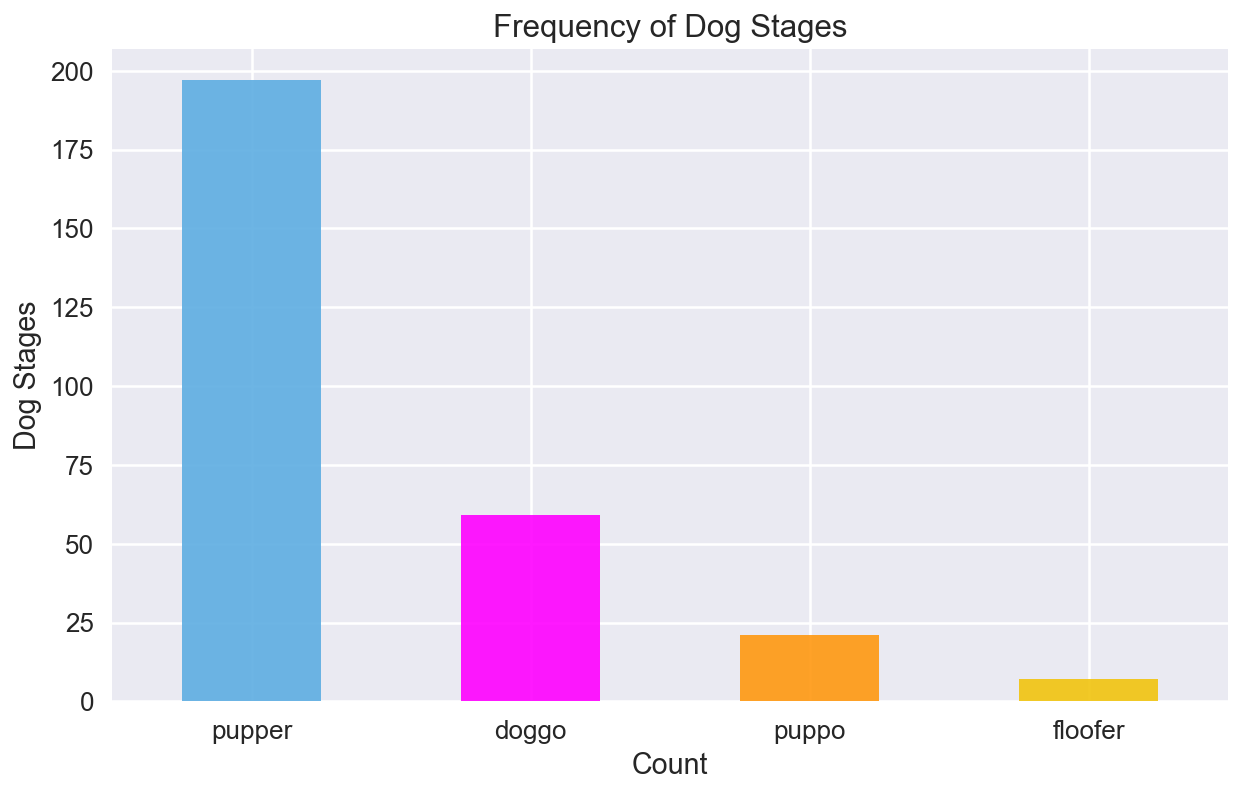

In [693]:
set_hue_palette()
sns.set_context('talk')
ax=twitter_archive_master.dog_stages.value_counts()[:-3].plot.bar(alpha=0.9,figsize=(10,6))
%config InlineBackend.figure_format ='retina'
ax.set(xlabel="Count", ylabel="Dog Stages")
#ax.tick_params(axis='x',rotation=90)
plt.xticks(rotation='horizontal')
plt.title('Frequency of Dog Stages')
plt.show()

>### **2) Which dog_type occurs most frequently**

In [694]:
twitter_dog_types_freq=twitter_archive_master[twitter_archive_master.dog_type != 'not_dog']

In [695]:
twitter_dog_types_freq.groupby('dog_type')['tweet_id'].count().sort_values(ascending=False)[:20]

dog_type
golden_retriever            140
labrador_retriever          101
pembroke                     93
chihuahua                    86
pug                          60
toy_poodle                   49
chow                         45
pomeranian                   41
samoyed                      38
malamute                     32
chesapeake_bay_retriever     31
french_bulldog               30
cocker_spaniel               26
miniature_pinscher           23
eskimo_dog                   22
german_shepherd              21
shih-tzu                     20
siberian_husky               20
cardigan                     19
beagle                       19
Name: tweet_id, dtype: int64

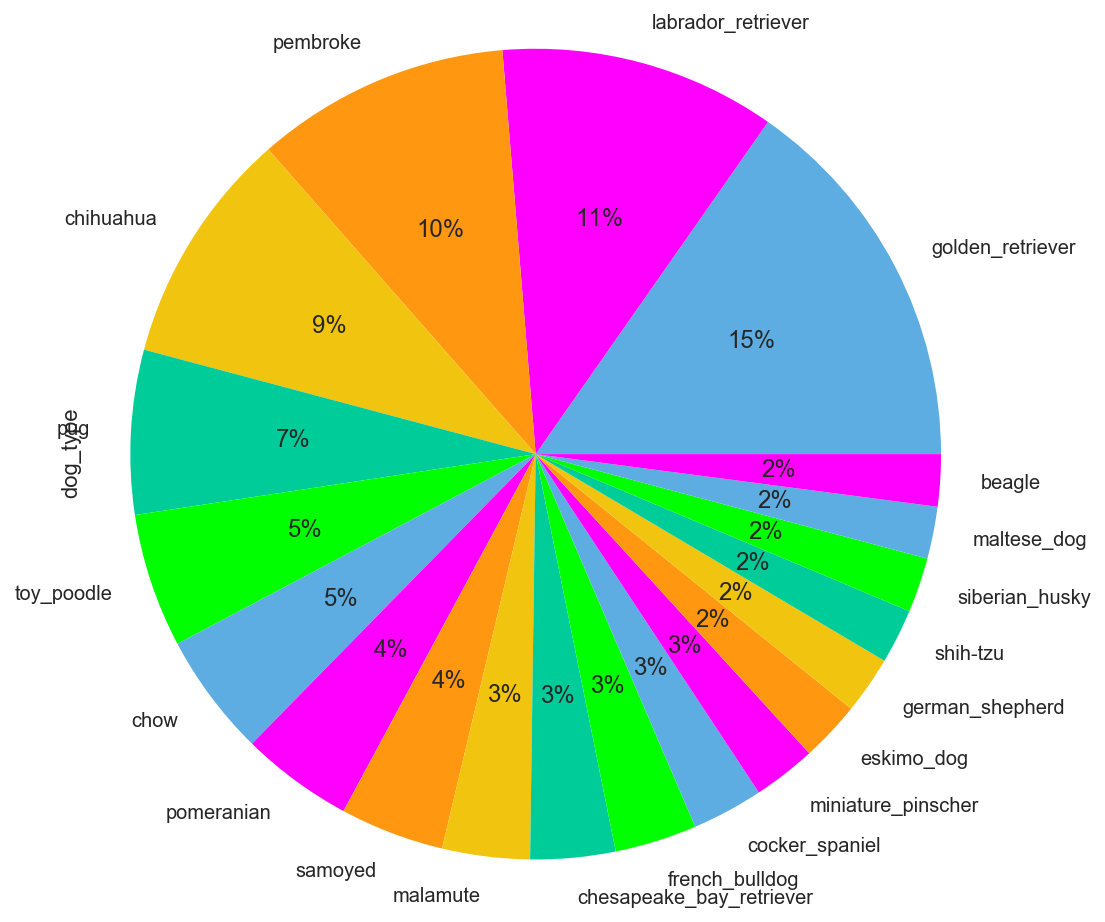

In [696]:
set_hue_palette()
ax=twitter_dog_types_freq.dog_type.value_counts()[:20].plot.pie(autopct='%.0f%%',figsize=(8,8))
ax.axis('equal')
plt.show()

In [697]:
ax1=twitter_dog_types_freq.dog_type.value_counts()[:4]
ax1

golden_retriever      140
labrador_retriever    101
pembroke               93
chihuahua              86
Name: dog_type, dtype: int64

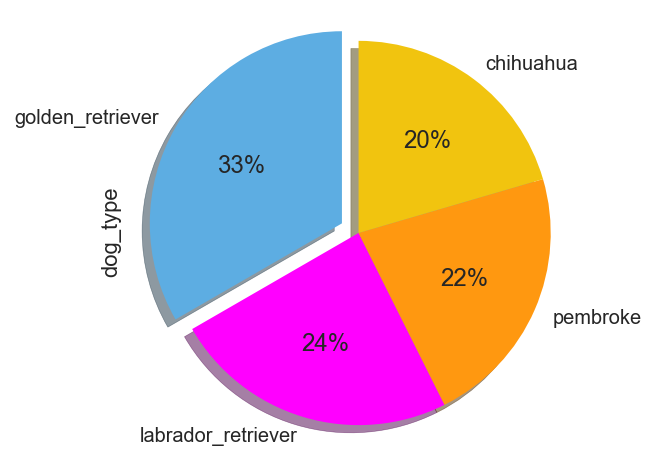

In [698]:
ax=ax1.plot.pie(explode=(0.1,0,0,0),shadow=True,startangle=90,autopct='%.0f%%',figsize=(4,4))
ax.axis('equal')
plt.show()

> comparing the top 4 dog types

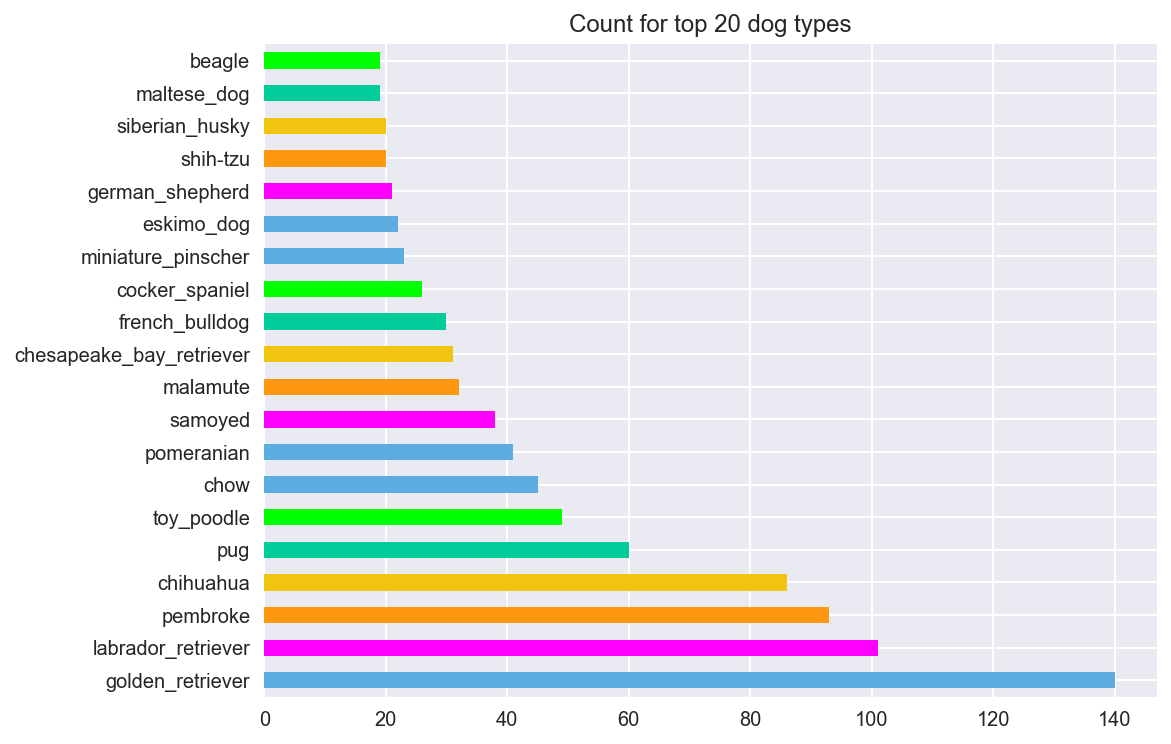

In [699]:
set_hue_palette()
twitter_dog_types_freq.dog_type.value_counts()[:20].plot.barh(figsize=(8,6))
plt.title('Count for top 20 dog types')
plt.show()

In [700]:
#dog types with more than 25 dogs represented in the dataframe
twitter_dog_types_25=twitter_dog_types_freq.groupby('dog_type').filter(lambda x: len(x) >=25)

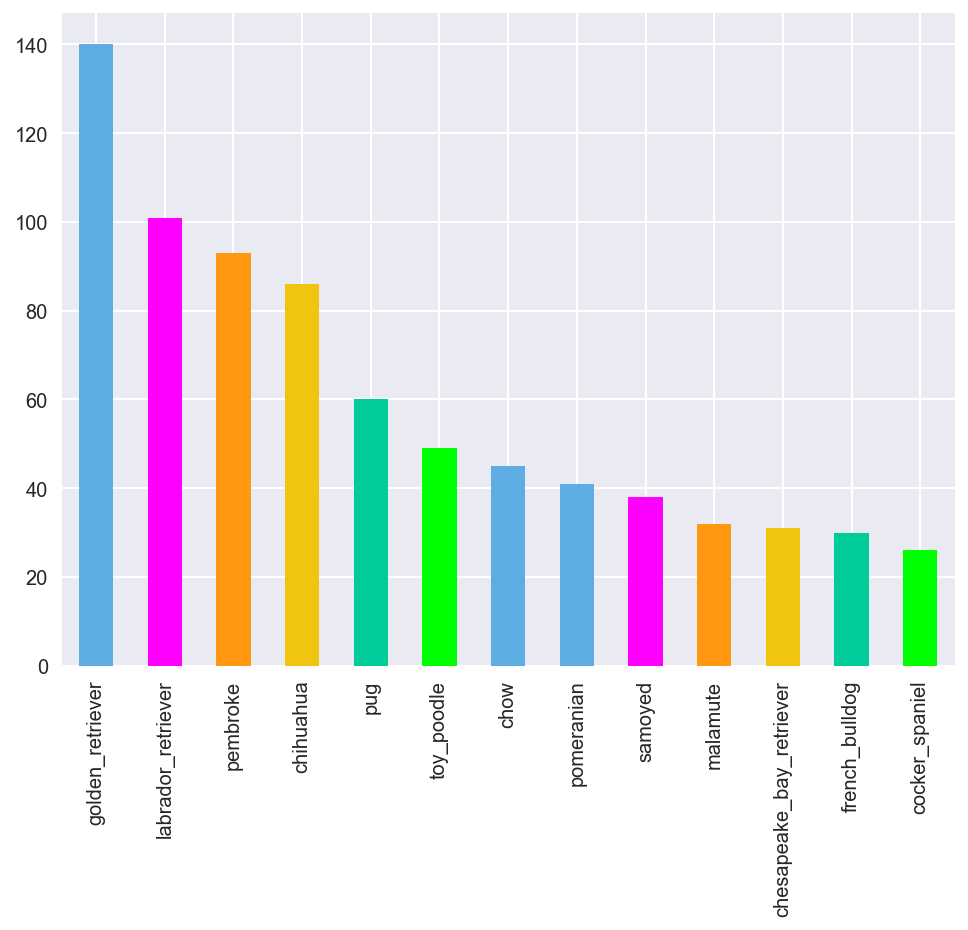

In [701]:
twitter_dog_types_25.dog_type.value_counts().plot.bar(figsize=(8,6))
plt.show()

> ### 3) **Most popular Dog Name?**

In [702]:
twitter_archive_master.name.value_counts().sort_values(ascending=False)[:10]

Charlie    11
Cooper     10
Lucy       10
Oliver     10
Penny       8
Sadie       8
Tucker      8
Winston     8
Daisy       7
Toby        7
Name: name, dtype: int64

> **Charlie is the most popular dog name**

In [703]:
twitter_archive_master[['dog_type','tweet_id','expanded_urls']][twitter_archive_master.name=='Charlie']

,dog_type,tweet_id,expanded_urls
190,not_dog,844580511645339650,https://twitter.com/dog_rates/status/844580511...
195,labrador_retriever,842846295480000512,https://twitter.com/dog_rates/status/842846295...
239,chihuahua,833826103416520705,https://twitter.com/dog_rates/status/833826103...
247,kelpie,832369877331693569,https://twitter.com/dog_rates/status/832369877...
280,great_dane,827199976799354881,https://twitter.com/dog_rates/status/827199976...
550,labrador_retriever,771102124360998913,https://twitter.com/dog_rates/status/771102124...
642,french_bulldog,754011816964026368,https://twitter.com/dog_rates/status/754011816...
999,golden_retriever,703382836347330562,https://twitter.com/dog_rates/status/703382836...
1069,great_dane,697255105972801536,https://twitter.com/dog_rates/status/697255105...
1275,chihuahua,681891461017812993,https://twitter.com/dog_rates/status/681891461...


In [704]:
charlie_imgs=list(twitter_archive_master['tweet_id'][twitter_archive_master.name=='Charlie'])

In [705]:
charlie_imgs

[844580511645339650,
 842846295480000512,
 833826103416520705,
 832369877331693569,
 827199976799354881,
 771102124360998913,
 754011816964026368,
 703382836347330562,
 697255105972801536,
 681891461017812993,
 671504605491109889]

In [706]:
predictions_df_alt.tweet_id=predictions_df_alt.tweet_id.astype('int')

In [707]:
image = predictions_df_alt[predictions_df_alt.tweet_id.isin(charlie_imgs)]['jpg_url']
dups = image.duplicated()
image = image[~dups]
image_url = image.values[8]
Image(url= image_url, width=300, height=300)

> **An example of a dog named Charlie**

<a id='2'></a>
### Insight 2 & Visualization

**Which dog stage is most highly rated**

> ### **1) Which dog stage is most highly rated?**

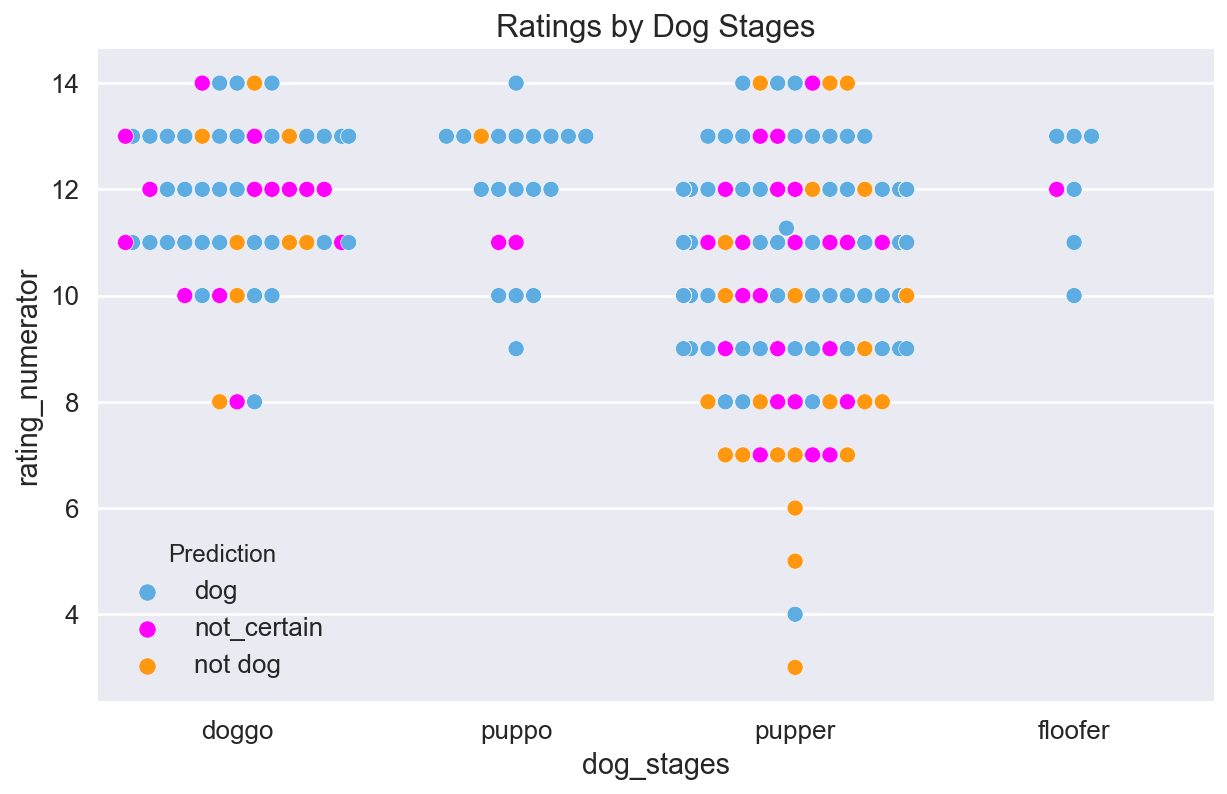

In [708]:
plt.figure(figsize=(10,6))
set_hue_palette()
sns.set_context('talk')
sns.swarmplot(data=twitter_archive_master_stages,size=8,linewidth=0.3,edgecolor='w',
              hue='Prediction',y='rating_numerator',x='dog_stages')
plt.title('Ratings by Dog Stages')
plt.show()

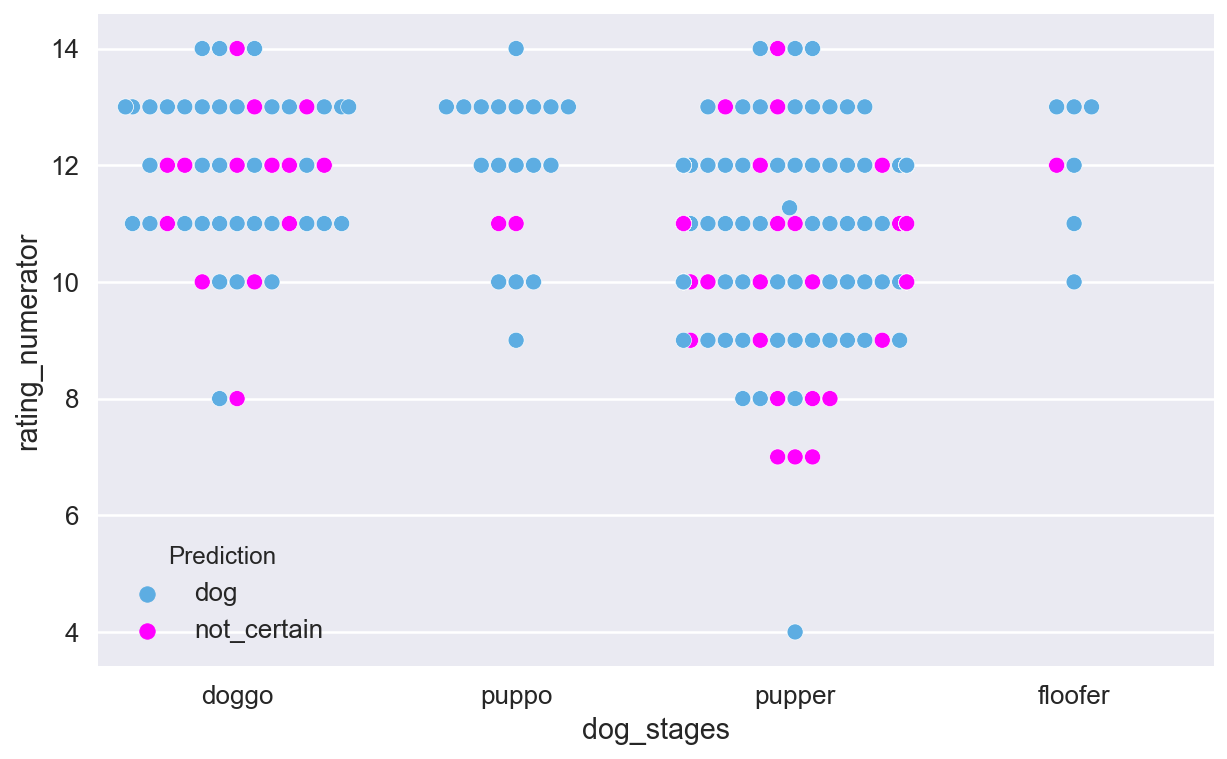

In [709]:
plt.figure(figsize=(10,6))
set_hue_palette()
sns.set_context('talk')
sns.swarmplot(data=df_x_not_dog,size=8,linewidth=0.3,edgecolor='w',
              hue='Prediction',y='rating_numerator',x='dog_stages')
plt.show()

In [710]:
#plt.figure(figsize=(10,6))
#set_hue_palette()
#sns.set_context('talk')
#sns.swarmplot(data=df_x_not_dog_na,size=8,linewidth=0.3,edgecolor='w',
#              hue='Prediction',y='rating_numerator',x='dog_stages')
#plt.show()

In [711]:
#twitter_dog_types.dropna(inplace=True)

In [712]:
#set_hue_palette()
#plt.figure(figsize=(8,6))
#sns.set_context('talk')
#sns.barplot(x='dog_stages',y='rating_numerator',data=df_x_not_dog_na,hue='Prediction',alpha=0.7)
#plt.legend();

> **Seems like doggo is the more highly rated dog category because they have fewer entries to distort the average**

>### **2) Which Dog type are the highest and lowest rated?**

In [725]:
#find the average rating, then find the standard deviation
ttl_avg_rating,std_rating=twitter_dog_types_freq.rating_numerator.mean(),twitter_dog_types_freq.rating_numerator.std()
print("Overall Average Rating is : %.3f\nStandard Deviation of Rating is : %.3f" %(ttl_avg_rating,std_rating))

Overall Average Rating is : 10.761
Standard Deviation of Rating is : 1.836


In [714]:
dog_type_rated=twitter_dog_types_freq.groupby('dog_type')['rating_numerator'].mean()

In [726]:
dog_type_rated.sort_values(ascending=False)[:5]

dog_type
bouvier_des_flandres    13.000000
saluki                  12.500000
irish_setter            12.333333
briard                  12.333333
border_terrier          12.142857
Name: rating_numerator, dtype: float64

In [727]:
twitter_dog_types_freq.groupby('dog_type')['rating_numerator'].agg(['mean','std']).sort_values(('mean'))

,mean,std
dog_type,,
japanese_spaniel,5.000000,NaN
afghan_hound,8.000000,7.071068
soft-coated_wheaten_terrier,8.500000,3.006403
walker_hound,9.000000,1.732051
australian_terrier,9.000000,5.656854
scotch_terrier,9.000000,NaN
irish_terrier,9.200000,2.774887
ibizan_hound,9.250000,0.957427
tibetan_terrier,9.250000,2.061553


In [728]:
twitter_dog_types_freq[['tweet_id',
                        'dog_type',
                        'rating_numerator','text']][twitter_dog_types_freq.rating_numerator.isin(['5'])].sample(5)

,tweet_id,dog_type,rating_numerator,text
1377,677301033169788928,japanese_spaniel,5.0,This is Juckson. He's totally on his way to a ...
1540,672980819271634944,basset,5.0,Extraordinary dog here. Looks large. Just a he...
658,751583847268179968,dalmatian,5.0,Please stop sending it pictures that don't eve...
1091,694352839993344000,australian_terrier,5.0,Meet Oliviér. He takes killer selfies. Has a d...
1735,668994913074286592,english_springer,5.0,Two gorgeous pups here. Both have cute fake ho...


In [729]:
rated_least=list(twitter_dog_types_freq['tweet_id'][twitter_dog_types_freq.rating_numerator.isin([5])])

In [730]:
image = predictions_df_alt[predictions_df_alt.tweet_id.isin(rated_least)]['jpg_url']
dups = image.duplicated()
image = image[~dups]
image_url = image.values[4]
Image(url= image_url, width=300, height=300)

***

<a id='3'></a>
### Insight 3 & Visualization

### How do certian Variables or categories vary with respect to others?

> ### **1) How do the different dog_stage and dog_type differ with retweets and favourites?**

In [731]:
twitter_archive_master_stages.groupby(['dog_stages'])['retweet_count','favorite_count'].sum()

,retweet_count,favorite_count
dog_stages,,
doggo,362520.0,1049962.0
floofer,32239.0,87396.0
pupper,412432.0,1300996.0
puppo,130698.0,454749.0


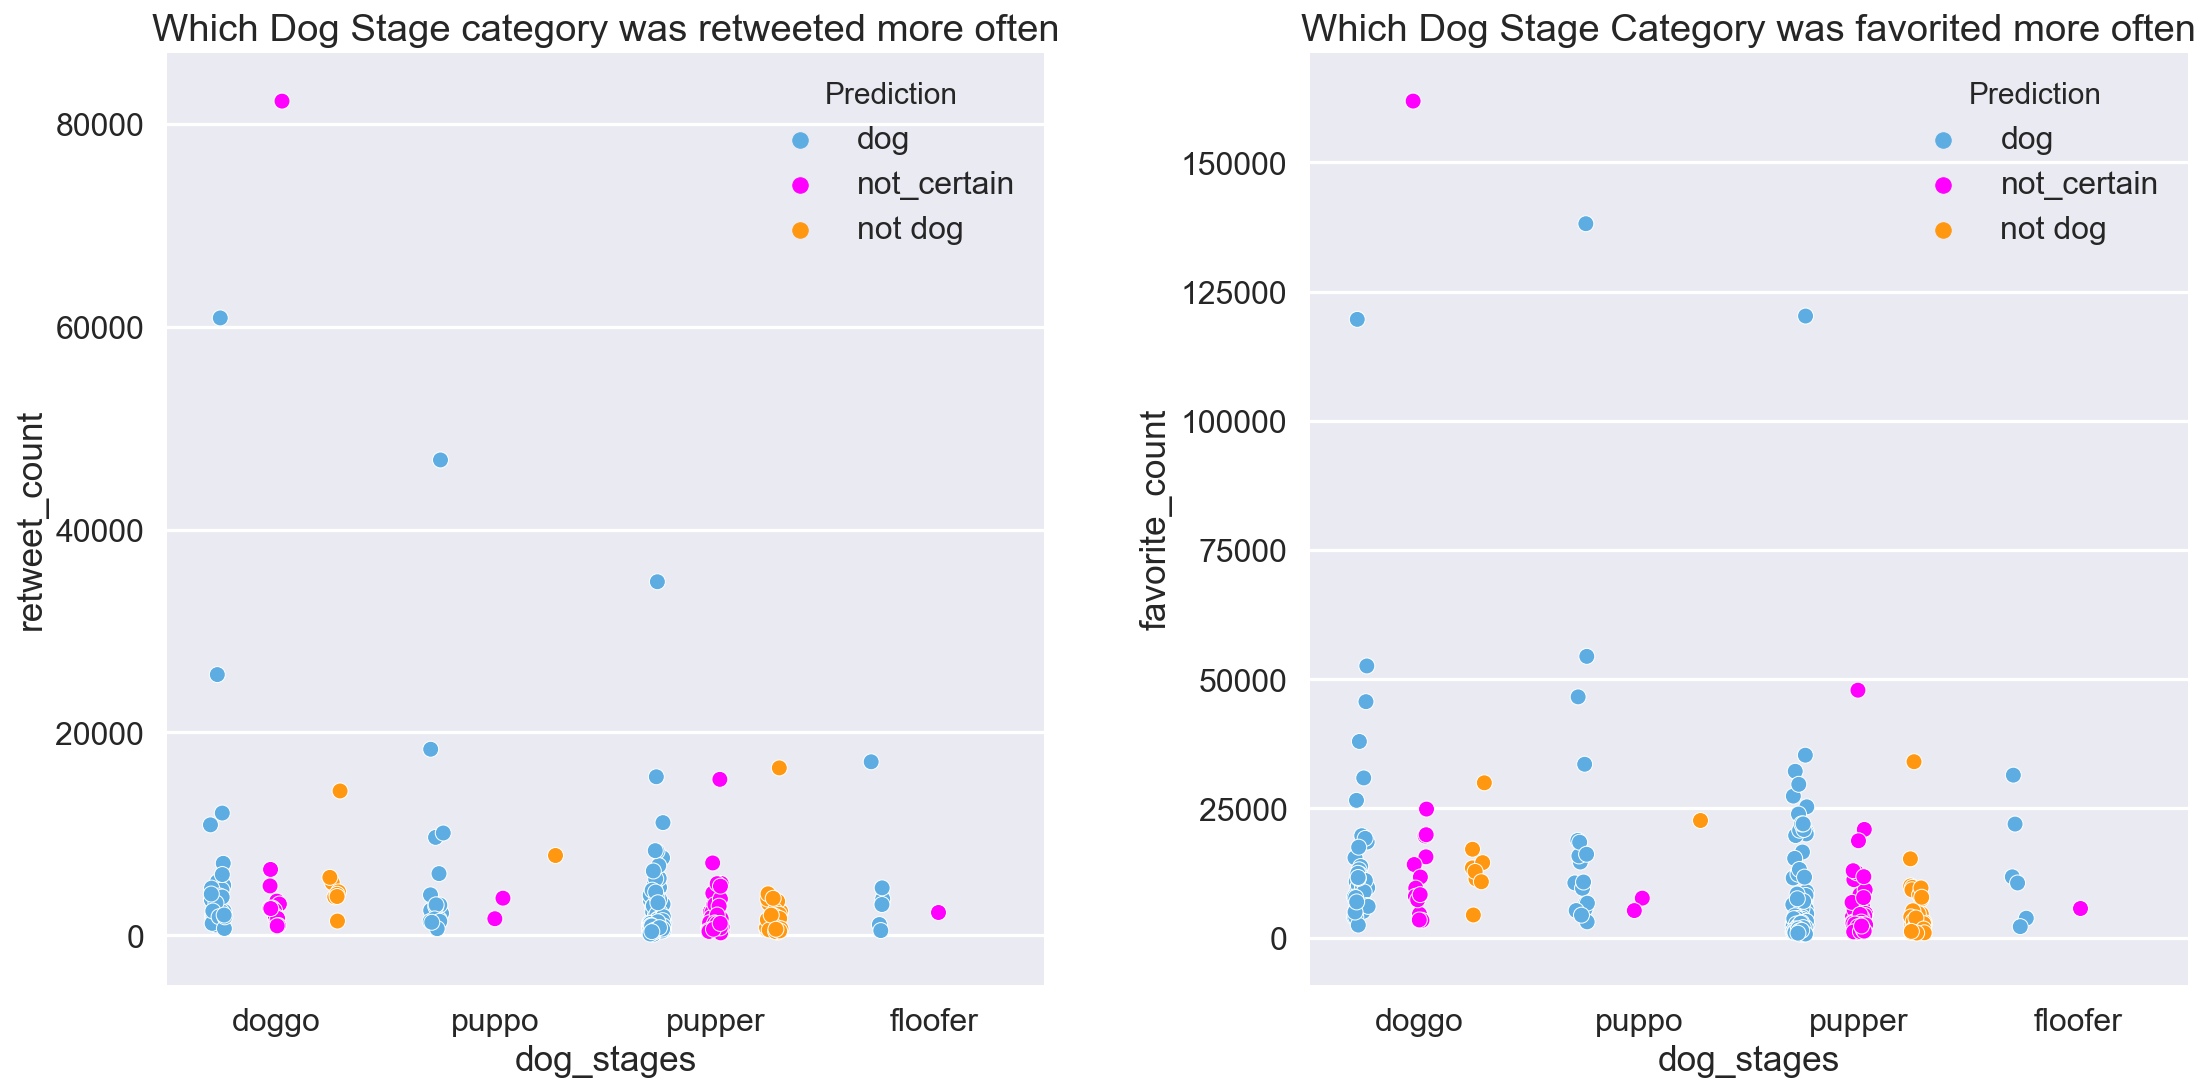

In [732]:
set_hue_palette()
sns.set_context('poster')
fig,ax=plt.subplots(figsize=(16,8),nrows=2,ncols=1)
plt.subplot(121)
plt.title('Which Dog Stage category was retweeted more often')
sns.stripplot(data=twitter_archive_master_stages,edgecolor='W',linewidth=0.5,
              size=8,hue='Prediction',x='dog_stages',y='retweet_count',jitter=True,dodge=True)

plt.subplot(122)
sns.stripplot(data=twitter_archive_master_stages,edgecolor='W',linewidth=0.5,
              size=8,hue='Prediction',x='dog_stages',y='favorite_count',jitter=True,dodge=True)
plt.title('Which Dog Stage Category was favorited more often')

plt.tight_layout()
plt.show()

In [733]:
#sns.set_context('talk')
#plt.figure(figsize=(10,6))
#sns.boxplot(x=twitter_archive_master_stages['dog_stages'],y=twitter_dog_types['retweet_count'])
#set_hue_palette()

> ### **2) How does the rating vary with the retweet and favorite counts?**
**Is it a causal relationship?**

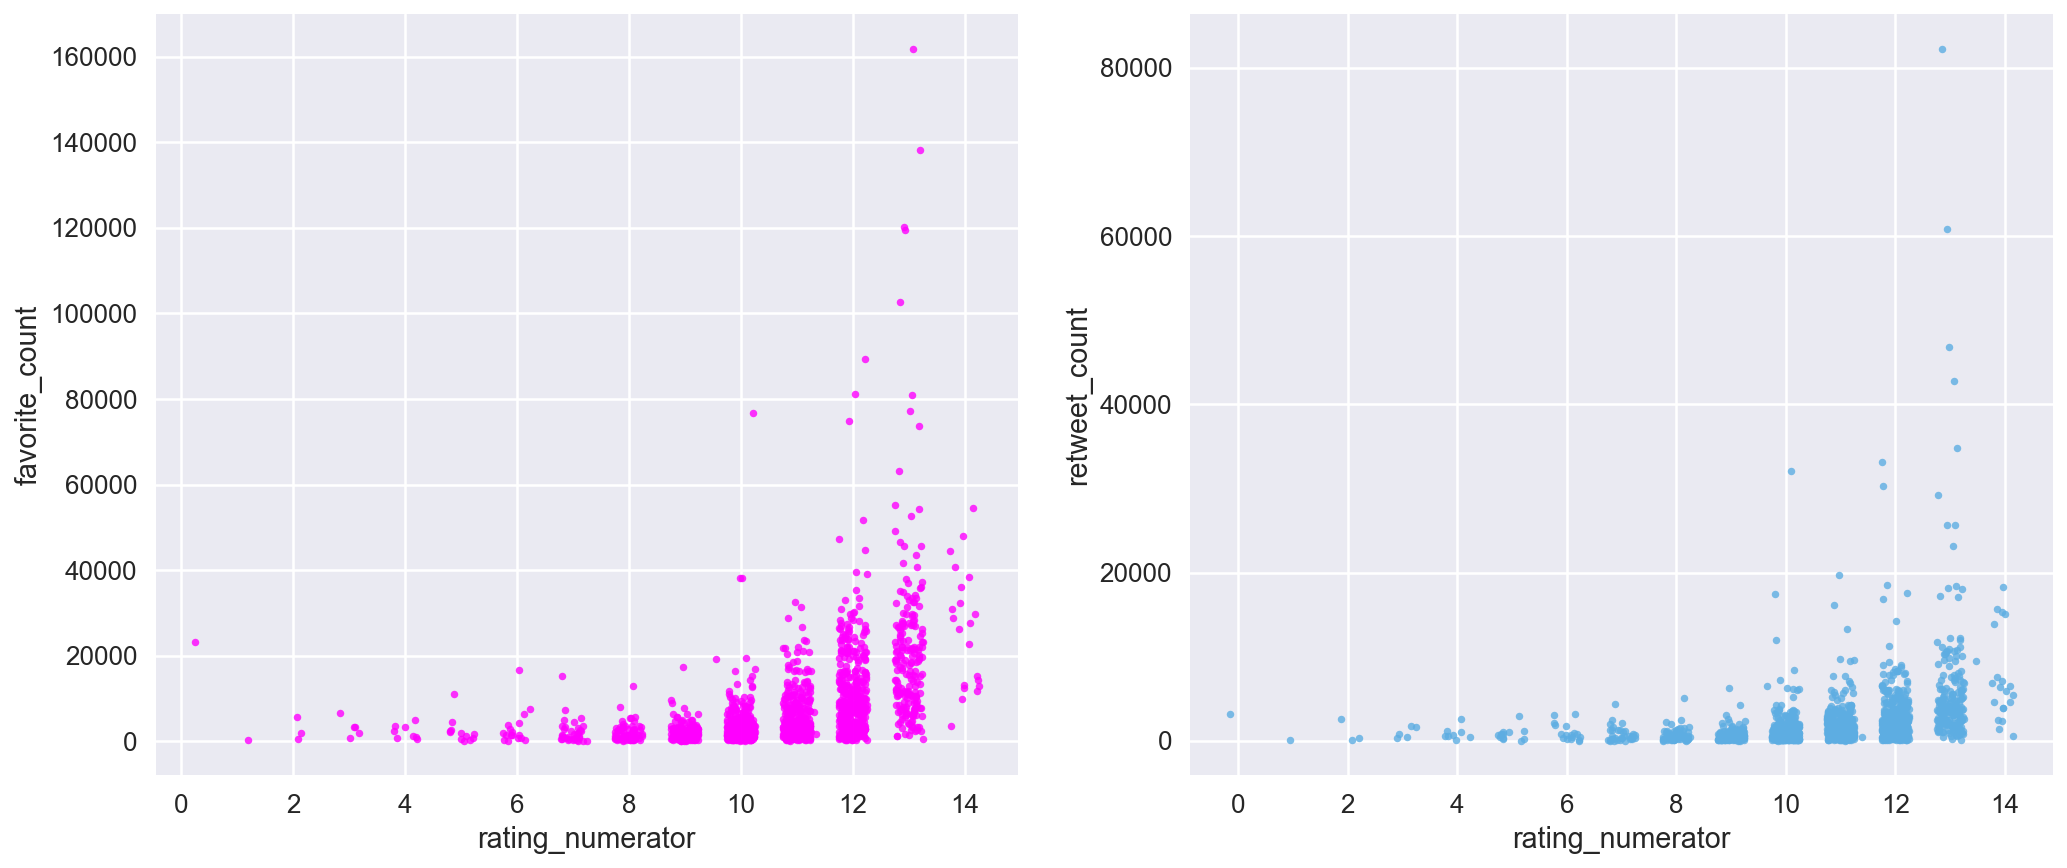

In [734]:
set_hue_palette()
sns.set_context('talk')
plt.subplots(figsize=(17,7))
plt.subplot(121)
sns.regplot(scatter=True,logx=True,fit_reg=False,x_jitter=0.25,
            scatter_kws={'alpha': 0.8, 's': 14}, 
            color=my_palette[-5],
            x=twitter_dog_types_freq['rating_numerator'],
            y=twitter_dog_types_freq['favorite_count'],
            dropna=True)

plt.subplot(122)
sns.regplot(scatter=True,logx=True,fit_reg=False,x_jitter=0.25,
            scatter_kws={'alpha': 0.8, 's': 14}, 
            color=my_palette[-6],
            x=twitter_dog_types_freq['rating_numerator'],
            y=twitter_dog_types_freq['retweet_count'],
            dropna=True)
plt.show()

>### **3) How does retweet_count correlate with favorite_count**

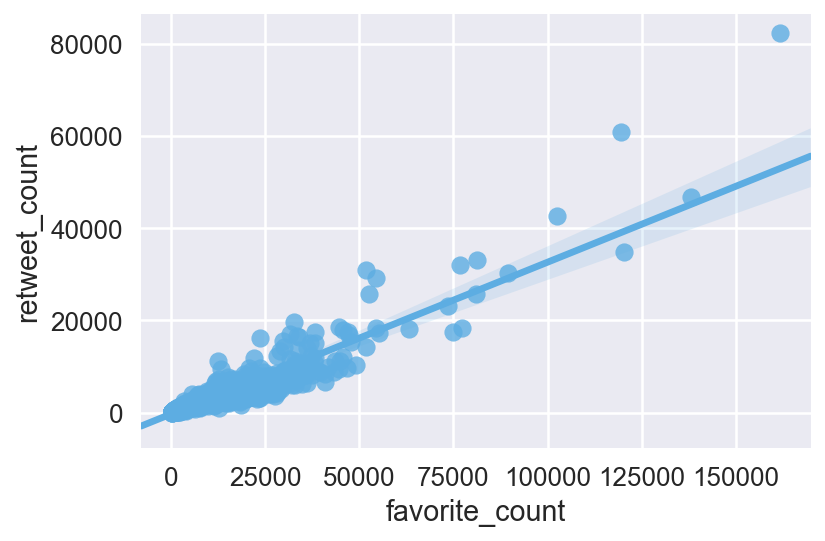

In [735]:
plt.figure(figsize=(6,4))
sns.regplot(scatter=True,
            y=twitter_archive_master['retweet_count'],
            x=twitter_archive_master['favorite_count'],
            dropna=True)
sns.set_context('talk')

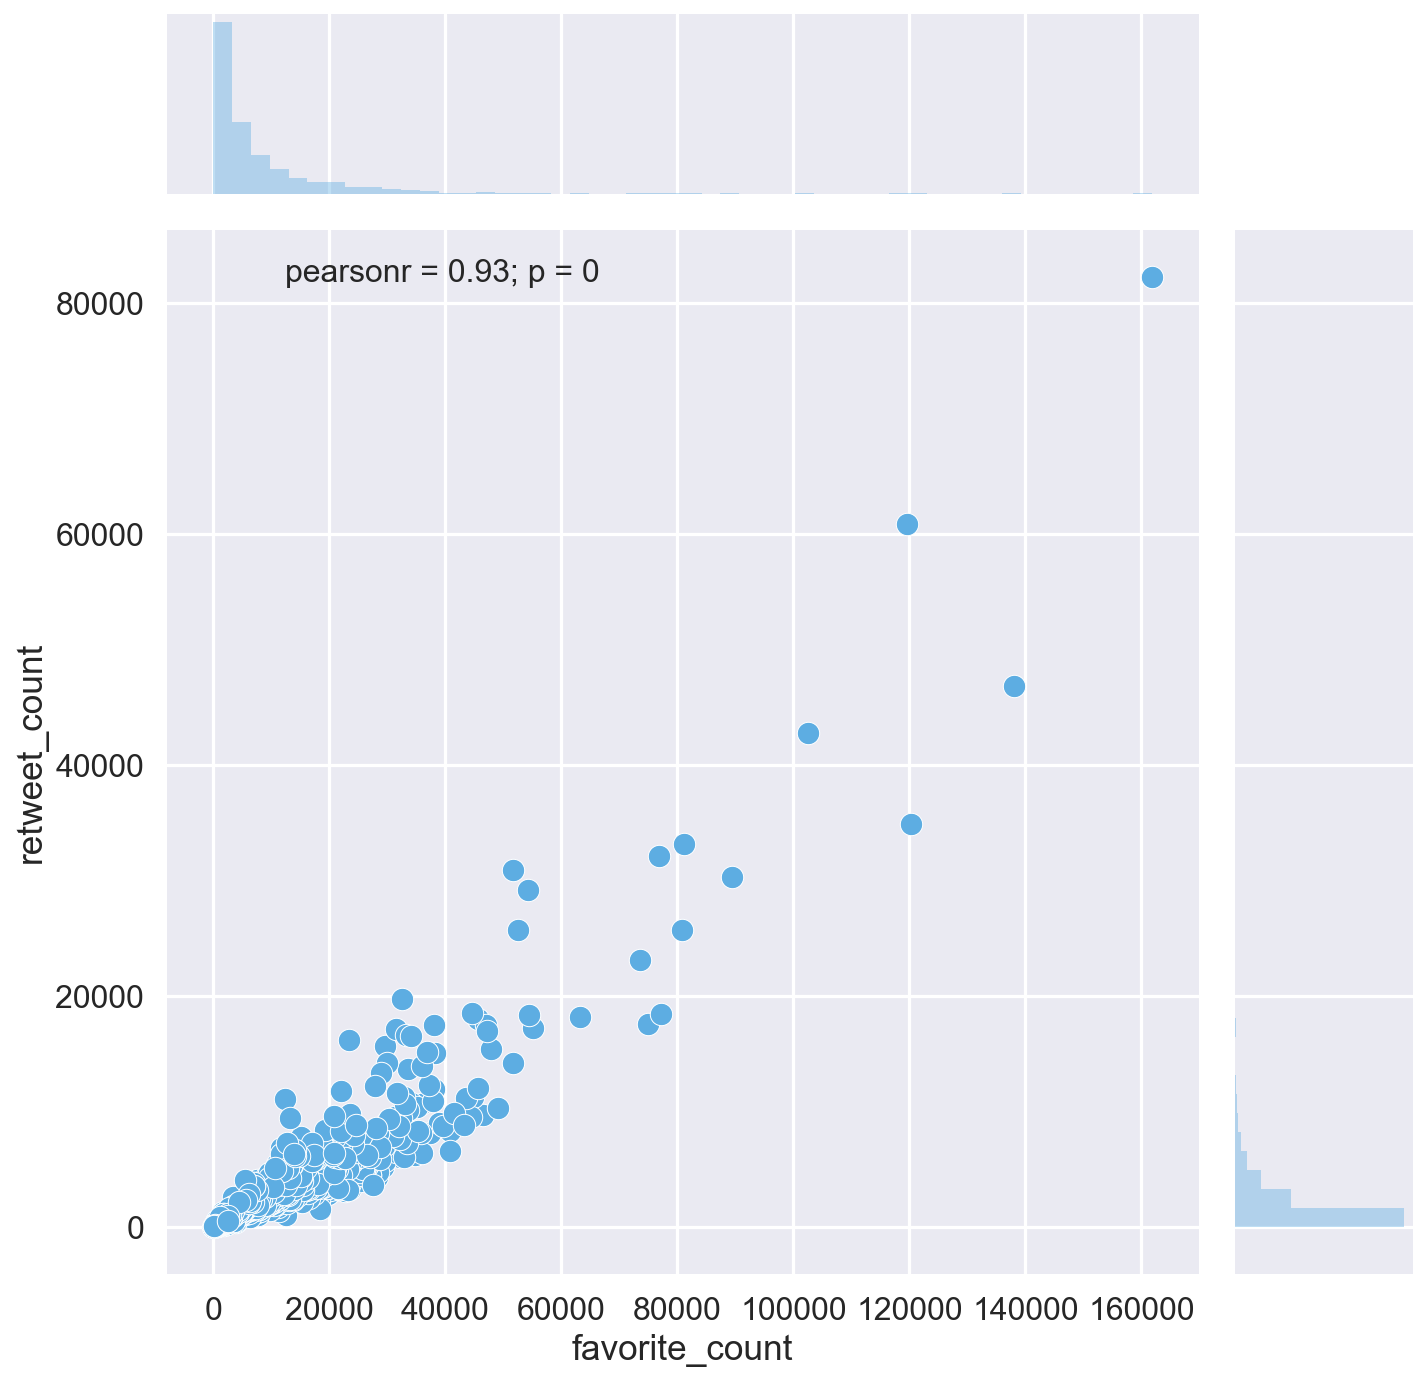

In [736]:
sns.set_context('poster')
sns.jointplot(size=10,edgecolor="w", linewidth=0.5,
            y=twitter_archive_master['retweet_count'],
            x=twitter_archive_master['favorite_count'],
            dropna=True)
set_hue_palette()

>### **4) How does the retweet count vary with the favourite count over time?**

In [737]:
twitter_archive_master.timestamp=pd.to_datetime(twitter_archive_master.timestamp)

In [738]:
max(twitter_archive_master.favorite_count)

161854.0

In [739]:
twitter_archive_master.favorite_count.describe()

count      1900.000000
mean       8037.541053
std       11797.172430
min          76.000000
25%        1764.500000
50%        3674.000000
75%        9812.750000
max      161854.000000
Name: favorite_count, dtype: float64

In [740]:
favs=twitter_archive_master.dropna(subset=['favorite_count'])

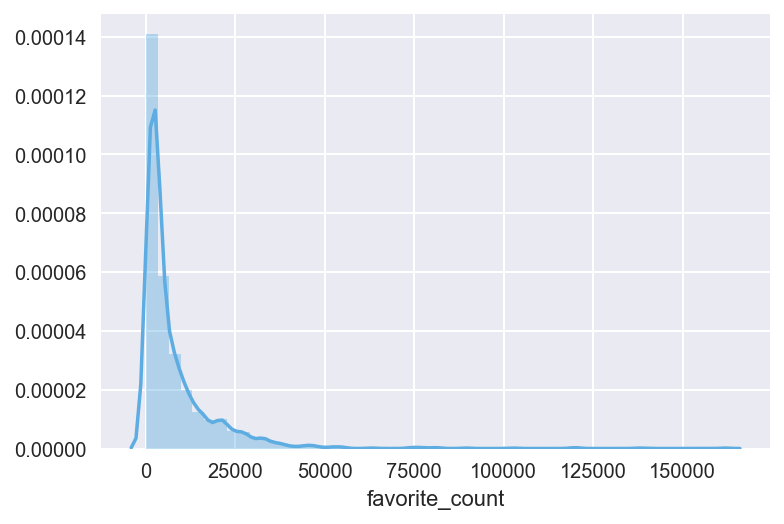

In [741]:
sns.distplot(favs.favorite_count)

In [742]:
time_plot=twitter_archive_master[twitter_archive_master.favorite_count<10000].timestamp.dt.date
retweets_plot=twitter_archive_master[twitter_archive_master.favorite_count < 10000].retweet_count
favorite_plot=twitter_archive_master[twitter_archive_master.favorite_count < 10000].favorite_count

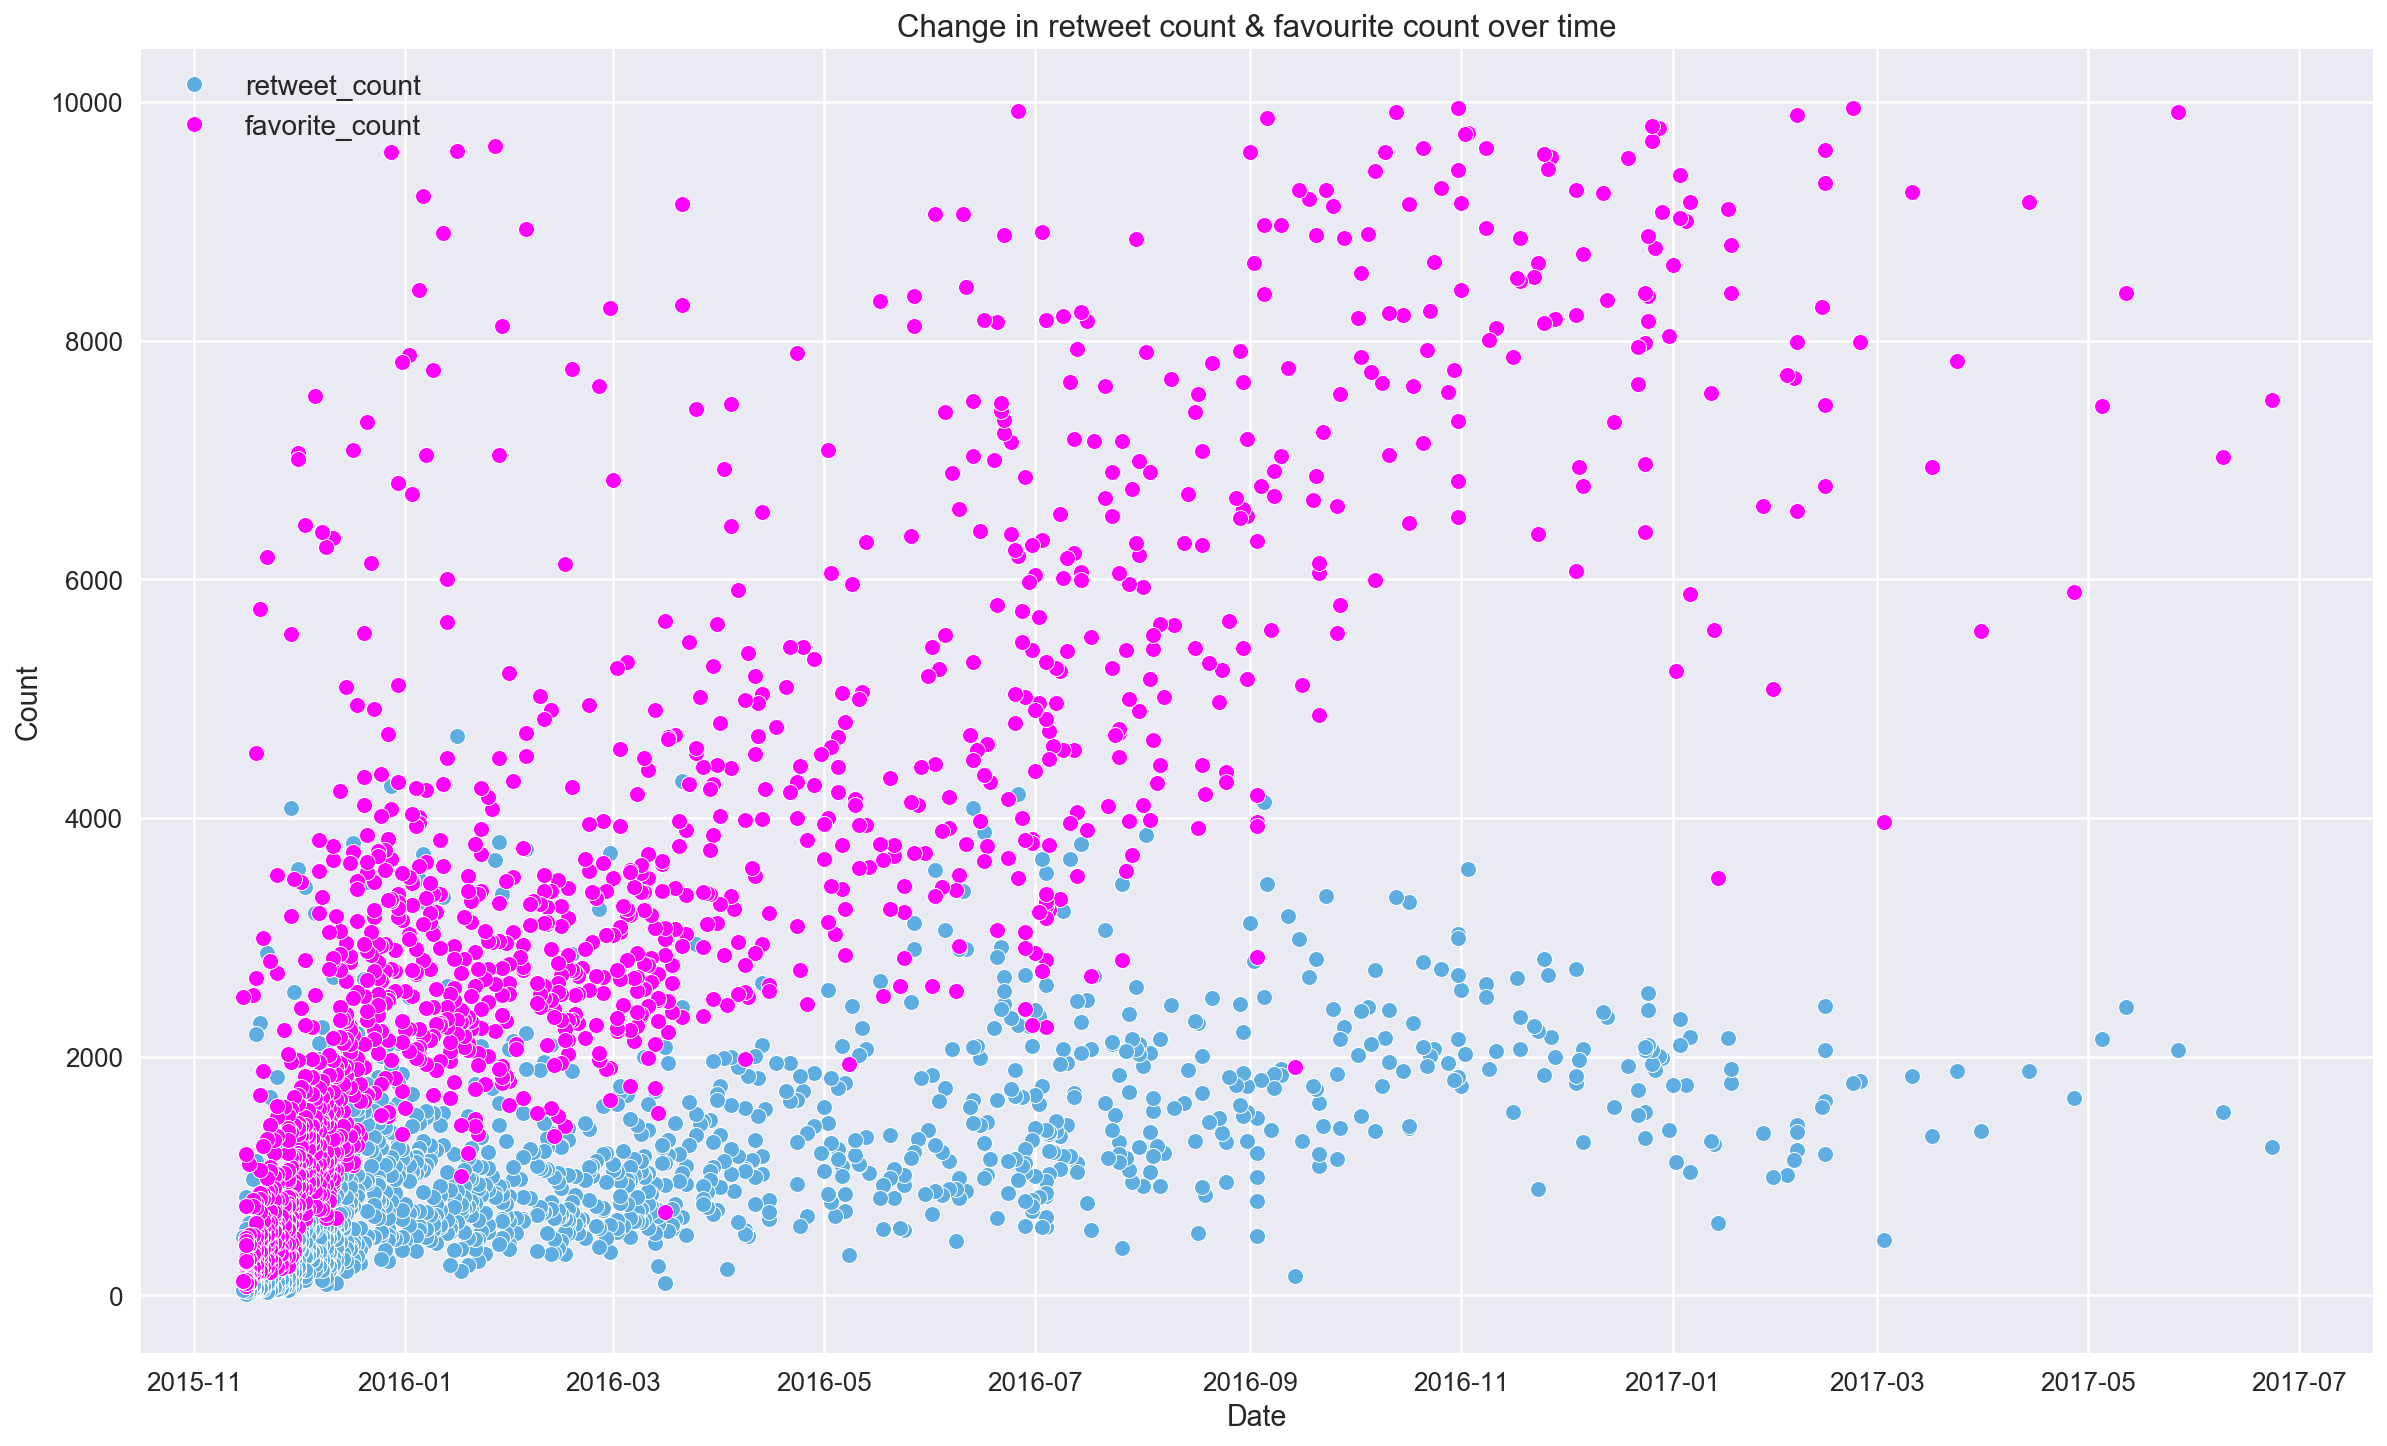

In [743]:
set_hue_palette()
sns.set_context('talk')
fig, ax=plt.subplots(figsize=(20,12))
plt.plot_date(time_plot,retweets_plot,markeredgecolor='w',markeredgewidth=0.5,markersize=8)
plt.plot_date(time_plot,favorite_plot,markeredgecolor='w',markeredgewidth=0.5,markersize=8)

ax.set(xlabel='Date',ylabel='Count')
ax.legend(loc='upper left',prop={'size': 14})
plt.title('Change in retweet count & favourite count over time')
plt.show()

<a id='4'></a>
### Insight 4 & Visualization

**PREDICTOR**

> * **How efficient was the neural network at predicting the images of the dogs?**
* **How did the top three predicted images fair?**

In [744]:
testing=twitter_archive_master_stages.groupby(['dog_stages','dog_type'])['p1_conf'].mean()
testing

dog_stages  dog_type                      
doggo       basset                            0.999318
            beagle                            0.571229
            bedlington_terrier                0.395849
            blenheim_spaniel                  0.113992
            border_collie                     0.442534
            borzoi                            0.742912
            boston_bull                       0.237620
            boxer                             0.539036
            briard                            0.504427
            chesapeake_bay_retriever          0.480048
            chihuahua                         0.955156
            cocker_spaniel                    0.409388
            dandie_dinmont                    0.394404
            english_setter                    0.339324
            eskimo_dog                        0.503372
            german_shepherd                   0.582957
            german_short-haired_pointer       0.835491
            golden_ret

In [745]:
testing2=twitter_archive_master_stages.groupby(['p1'])['p1_conf'].mean().sort_values(ascending=False)
testing2

p1
swing                             0.999984
barrow                            0.999962
dalmatian                         0.999828
geyser                            0.991273
ski_mask                          0.981017
bernese_mountain_dog              0.977166
komondor                          0.974781
carton                            0.952613
clumber                           0.946718
web_site                          0.942605
mortarboard                       0.936882
german_short-haired_pointer       0.885631
rhodesian_ridgeback               0.885301
french_bulldog                    0.878647
tub                               0.873010
black-and-tan_coonhound           0.854861
motor_scooter                     0.835819
pomeranian                        0.825784
maltese_dog                       0.818145
sorrel                            0.811520
miniature_pinscher                0.763138
cardigan                          0.758598
toy_poodle                        0.748561
pug     

In [746]:
#slice of df for when the first nural net p1 predicted a dog but p2,p3 predicted something else
predictions_image_alt[['tweet_id','p1_conf','p1','jpg_url']][(predictions_image_alt.p1_dog==1) 
                                                   & (predictions_image_alt.p2_dog==0)
                                                  & (predictions_image_alt.p3_dog==0)].sample(5)

,tweet_id,p1_conf,p1,jpg_url
595,679511351870550016,0.761972,chihuahua,https://pbs.twimg.com/media/CW4b-GUWYAAa8QO.jpg
1140,729823566028484608,0.218408,kelpie,https://pbs.twimg.com/media/CiDap8fWEAAC4iW.jpg
1305,753375668877008896,0.360071,bluetick,https://pbs.twimg.com/media/CnSHLFeWgAAwV-I.jpg
597,679530280114372609,0.750256,dalmatian,https://pbs.twimg.com/media/CW4tL1vWcAIw1dw.jpg
890,699323444782047232,0.309696,labrador_retriever,https://pbs.twimg.com/media/CbR-9edXIAEHJKi.jpg


In [747]:
p1_predicted_dog=predictions_image_alt['jpg_url'][(predictions_image_alt.p1_dog==1) 
                                                   & (predictions_image_alt.p2_dog==0)
                                                  & (predictions_image_alt.p3_dog==0)].tolist()

In [748]:
image_url = p1_predicted_dog[5]
Image(url= image_url, width=250, height=250)

> lets check an entry at index 1473 with tweet_id "*780192070812196864*" where the first predictor p1 predicted the image as a dog while the others didn't.

In [749]:
#p1 predicts image as dog despite the spring thingy on dogs head
Image(url=predictions_image_alt.loc[1473,'jpg_url'],width=250,height=250)


In [750]:
#lets check another image which p1 predicts as dog with high confidence.
Image(url=predictions_image_alt.loc[149,'jpg_url'],width=250,height=250)


> **p1 predicts image as dog despite with very high confidence while others(p1,p2,p3) predicted it as not a dog.**

In [751]:
#slice of df for when the first neural net p1 predicted a dog but p2,p3 predicted something else
not_dog_entries=predictions_image_alt[['tweet_id','p1_conf','p1',
       'p2_conf', 'p2','p3_conf', 'p3']][predictions_image_alt.Prediction=='not dog']

In [752]:
not_dog_entries.sort_values(by='p1_conf',ascending=False)[:7]

,tweet_id,p1_conf,p1,p2_conf,p2,p3_conf,p3
106,667866724293877760,1.000000,jigsaw_puzzle,1.011300e-08,prayer_rug,1.740170e-10,doormat
230,670408998013820928,0.999945,ping-pong_ball,1.763430e-05,tennis_ball,1.470730e-05,racket
242,670449342516494336,0.999924,peacock,2.987300e-05,european_gallinule,2.150760e-05,agama
45,666786068205871104,0.999888,snail,5.514170e-05,slug,2.625800e-05,acorn
594,679503373272485890,0.999846,porcupine,7.191480e-05,meerkat,4.447290e-05,echidna
1725,820078625395449857,0.999833,school_bus,1.596210e-04,cab,1.799800e-06,crane
107,667873844930215936,0.999647,common_iguana,1.811500e-04,frilled_lizard,1.283570e-04,african_chameleon


In [753]:
Image(url=predictions_image_alt.loc[1725,'jpg_url'],width=250,height=250)


> **All the neural nets predict this as not a dog. but p1 predicts image as not dog with very high confidence while it correctly predicts it as a bus, there are dogs in the bus that it failed to identify.**

In [754]:
#lets check out the entries with the least prediction confidence by the first nural net p1
not_dog_entries.sort_values(by='p1_conf',ascending=True)[:7]

,tweet_id,p1_conf,p1,p2_conf,p2,p3_conf,p3
1093,719704490224398336,0.059033,home_theater,0.038299,window_shade,0.035528,bathtub
1370,762035686371364864,0.063152,home_theater,0.046692,cash_machine,0.046277,theater_curtain
246,670474236058800128,0.070076,wool,0.062536,siamang,0.058894,gorilla
701,684880619965411328,0.081101,clog,0.066957,spindle,0.060884,agama
1831,836380477523124226,0.082489,wooden_spoon,0.061017,sliding_door,0.055086,grand_piano
18,666268910803644416,0.086502,desktop_computer,0.085547,desk,0.079480,bookcase
301,671497587707535361,0.089165,swing,0.080747,paddle,0.065694,bathing_cap


In [755]:
Image(url=predictions_image_alt.loc[18,'jpg_url'],width=250,height=250)


> **The p1 neural net was incapable of noticing the dog on the chair and the dog on the screen it correctly identified the desktop computer though. It was not confident of it's prediction though so we'll cut it some slack.**

In [756]:
%config InlineBackend.figure_format ='retina'